<a href="https://colab.research.google.com/github/MagnsW/PhD_Colab/blob/main/Basic_test_complete_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.utils.vis_utils import plot_model

# User Parameters

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
dataset_size = 10000
load_models = True # Loading previously saved model. Retraining models if false.
auto_scale = False # Whether or not to automatically scale the number of kernels to the number of outputs. If False, 2 convolutional kernels are used.

In [5]:
path = '/gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/'

Above, the following model paths are used:


1.   Models_00: dataset_size = 10000; No normalization; auto_scale = False; length_kernel = 32;
2.   Models_01: dataset_size = 1000; Normalization; auto_scale = False; length_kernel = 32;
3.   Models_02: dataset_size = 10000; Normalization; auto_scale = False; length_kernel = 32; 
4.   Models_03: dataset_size = 1000; Normalization; auto_scale = False; length_kernel = 32; Improved dataset for interfering cw. FFT added
5.   Models_04: dataset_size = 10000; Normalization; auto_scale = False; length_kernel = 32; Improved dataset for interfering cw. FFT added


# CNN Network 

In [6]:
def makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs):
  model = Sequential()
  #model.add(tf.keras.layers.experimental.preprocessing.Normalization()) # Comment out if no normalization of input data
  model.add(Conv1D(no_kernels, length_kernel, activation='relu', padding='same', input_shape=input_shape))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(no_outputs, activation='linear'))
  return model

In [7]:
def plothistory(history):
  plt.figure(figsize=(16,10))
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.grid(which='both')
  plt.show()

In [8]:
def compile_and_train(X_train, y_train, filename, no_kernels=2,):
  length_kernel = 32
  no_outputs = y_train.shape[1]
  input_shape = (X_train.shape[1], X_train.shape[2]) # Only one trace per sample
  model = makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs)
  #plot_model(model, show_shapes=True, show_layer_names=True)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  history = model.fit(X_train, y_train, batch_size=20, epochs=100, verbose=1, validation_split=0.2, shuffle=True)
  plothistory(history)
  print(model.summary())
  model.save(filename)
  return model


In [9]:
def getmodel(X_train, y_train, filename, loadmodel=False, autoscale=True):
  if loadmodel:
    model = load_model(filename)
    print('Model loaded: ' + filename)
  else:
    if autoscale:
      no_kernels = y_train.shape[1]
    else:
      no_kernels = 2
    model = compile_and_train(X_train, y_train, filename, no_kernels=no_kernels)
    

  return model

# Continous Wave

## Helper functions

In [10]:
def makecwsignal(amp, freq, phase, samplingfreq=128, t_end=1):
  # Returns CW cosine signal based on input parameters
  dt = 1/samplingfreq
  t_array = np.arange(0, t_end, dt)
  y = amp*np.cos(2*np.pi*freq*t_array + phase)
  return y

In [11]:
def makerandom(n, source_central_freq=10, source_mag = 1, seed=42):
  ''' Returns random frequencies around central frequency, random phase and 
  random amplitude. Random phase between 0 and pi.
  '''
  rng = np.random.default_rng(seed)
  randfreqs = source_central_freq*(0.5+rng.random(n))
  #randphases = 2*np.pi*rng.random(n) #if multiplied with 2, between 0 and 2pi
  randphases = rng.uniform(low=1, high=2*np.pi-1, size=n) #Phase between 1 and 5.28
  randamps = source_mag*(0.5+rng.random(n))
  d = {'Amplitude': randamps, 'Frequency': randfreqs, 'Phase': randphases}
  return pd.DataFrame(data=d)

In [12]:
def plot_hists(df):
  numplots = len(df.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(df.columns):
    plt.subplot(1,numplots, i+1)
    plt.hist(df[attribute])
    plt.title(attribute)

In [13]:
def preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=False, noiselevel=0.1):
  if noiseon:
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
  else:
    traces = traces_clean
  df_traces = pd.DataFrame(traces)
  plt.plot(traces[0])
  plt.plot(traces[1])
  plt.show()
  plt.figure(figsize=(18, 10))
  plt.pcolormesh(df_traces.T)
  plt.gca().invert_yaxis()
  plt.show()

  plot_hists(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(df_traces, df_iterations, test_size=0.2, random_state=42)
  X_train = np.expand_dims(X_train, axis=2)
  X_train.shape, y_train.shape
  return X_train, X_test, y_train, y_test

### Prediction

In [14]:
def test_and_predict(model, X_test, y_test):
  if X_test.ndim < 3:
    X_test = np.expand_dims(X_test, axis=2)
  performance = model.evaluate(X_test, y_test)
  y_predict = model(X_test)
  df_y_predict = pd.DataFrame(y_predict.numpy(), columns=y_test.columns)
  return df_y_predict, performance


In [15]:
def plotprediction(data_truth, data_prediction):
  numplots = len(data_prediction.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(data_prediction.columns):
    plt.subplot(1,numplots, i+1)
    plt.scatter(data_truth[attribute], data_prediction[attribute])
    plt.plot([min(data_truth[attribute]), max(data_truth[attribute])], [min(data_truth[attribute]), max(data_truth[attribute])], 'r--' )
    plt.title('Predicted vs true ' + attribute)
    plt.grid(which='both')
  plt.show()

## Main section

In [16]:
df_iterations = makerandom(dataset_size)

In [17]:
traces_clean = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations['Amplitude'], df_iterations['Frequency'], df_iterations['Phase'])]

In [18]:
def scale_features(df_iterations): 
  # Features min-max scaling
  scaler = MinMaxScaler()
  scaler.fit(df_iterations)
  df_iterations_norm = pd.DataFrame(scaler.transform(df_iterations), columns=df_iterations.columns)
  return df_iterations_norm, scaler

In [19]:
def inverse_scale_features(df_iterations_norm, scaler):
  return pd.DataFrame(scaler.inverse_transform(df_iterations_norm), columns=df_iterations_norm.columns)

In [20]:
df_iterations_norm, scaler_iterations = scale_features(df_iterations)

### Clean

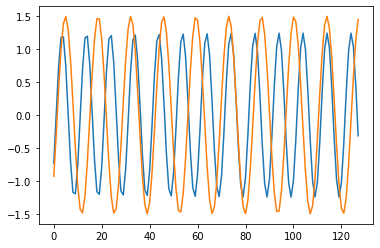

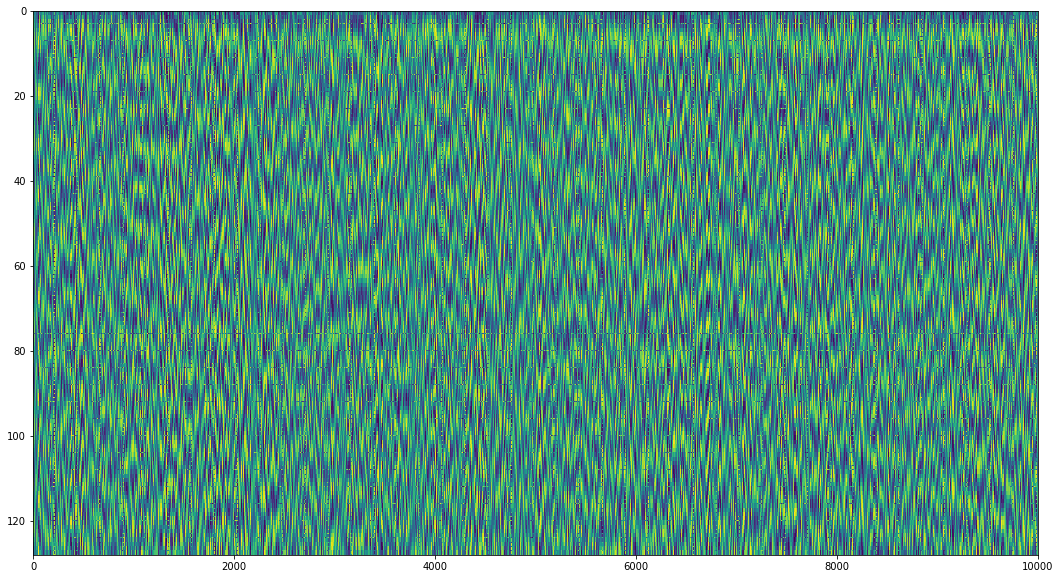

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_cw_clean


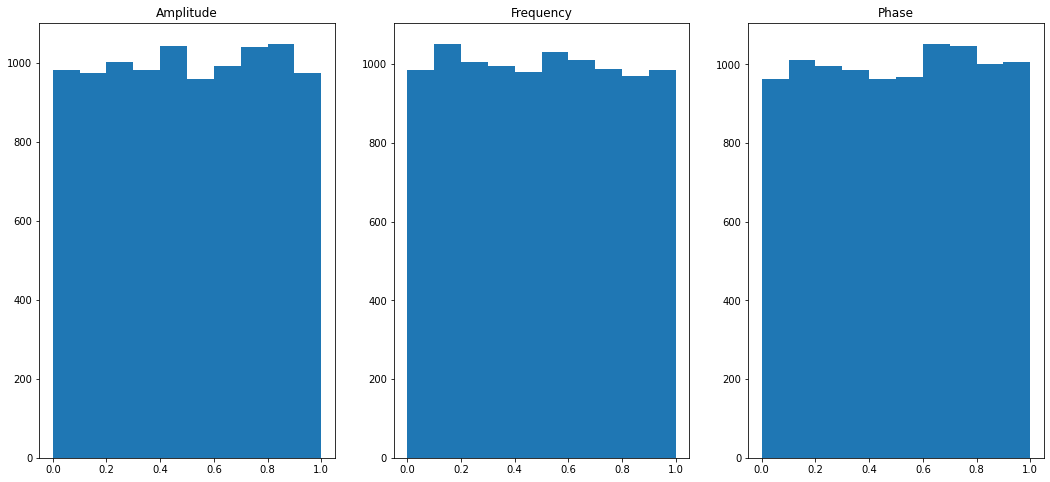

In [21]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(traces_clean, df_iterations_norm, noiseon=False)
modelname = 'model_cw_clean'
model_cw_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

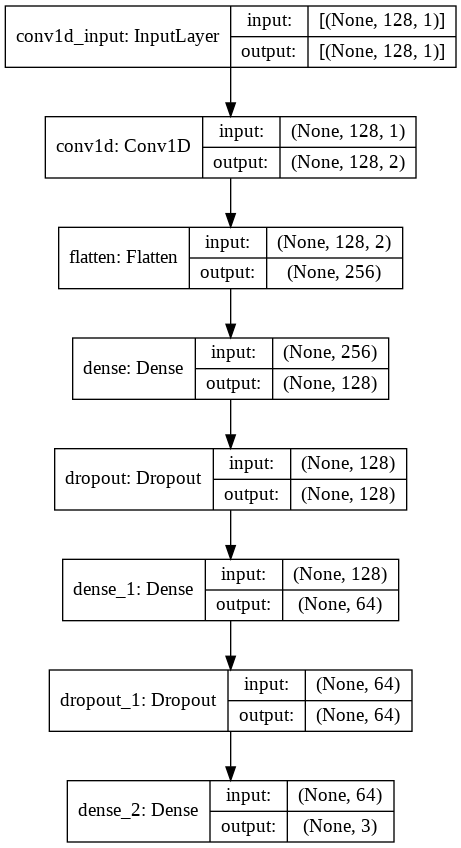

In [22]:
plot_model(model_cw_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 13s 2ms/step - loss: 2.6943e-04 - mse: 2.6943e-04 - mae: 0.0127


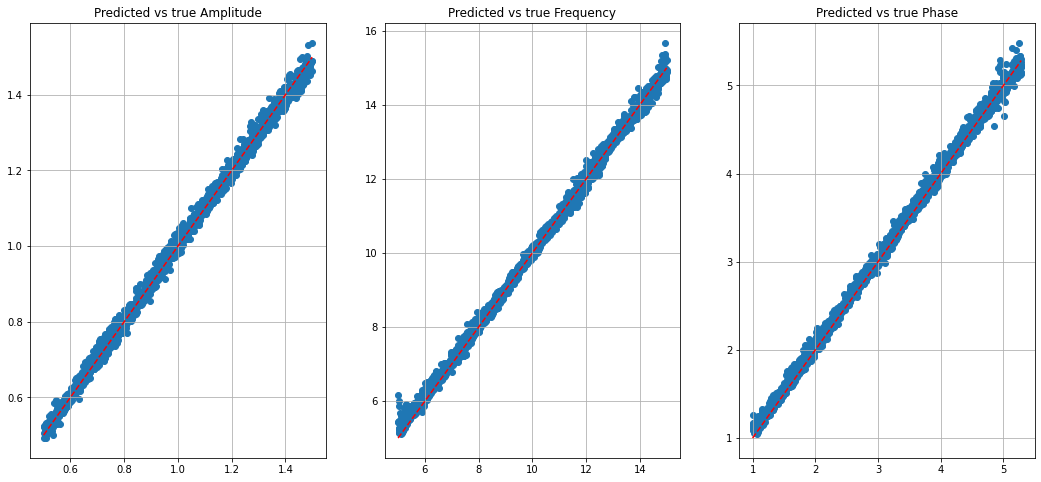

In [23]:
df_y_predict, performance = test_and_predict(model_cw_clean, X_test, y_test)
y_test_unscaled = inverse_scale_features(y_test, scaler_iterations)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [24]:
def addperformance(modelname, performance, df_performance=None):
  if df_performance is None:
    performance.insert(0, modelname)
    df_performance = pd.DataFrame([performance], columns=['ModelName', 'Loss', 'MSE', 'MAE'])
  else:
    df_length = len(df_performance)
    #print(df_performance) 
    #print(performance)
    df_performance.loc[df_length] = [modelname, performance[0], performance[1], performance[2]]
  performance.clear()

  return df_performance

In [25]:
df_performance = addperformance(modelname, performance)

### Noisy

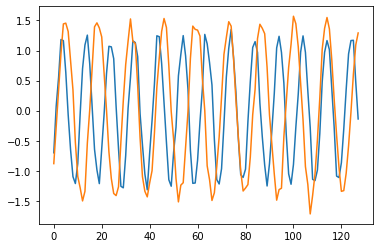

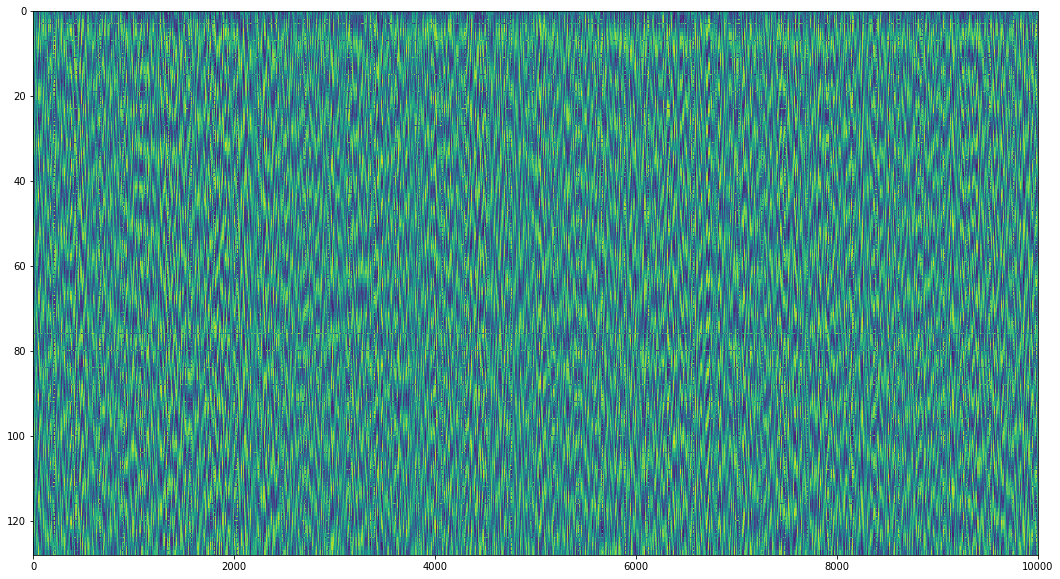

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_cw_noisy


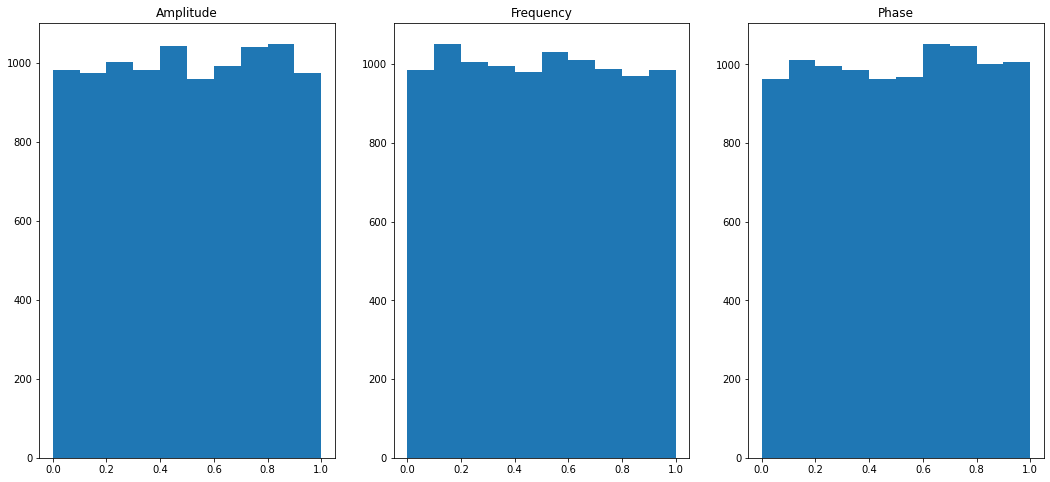

In [26]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(traces_clean, df_iterations_norm, noiseon=True)
modelname = 'model_cw_noisy'
model_cw_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

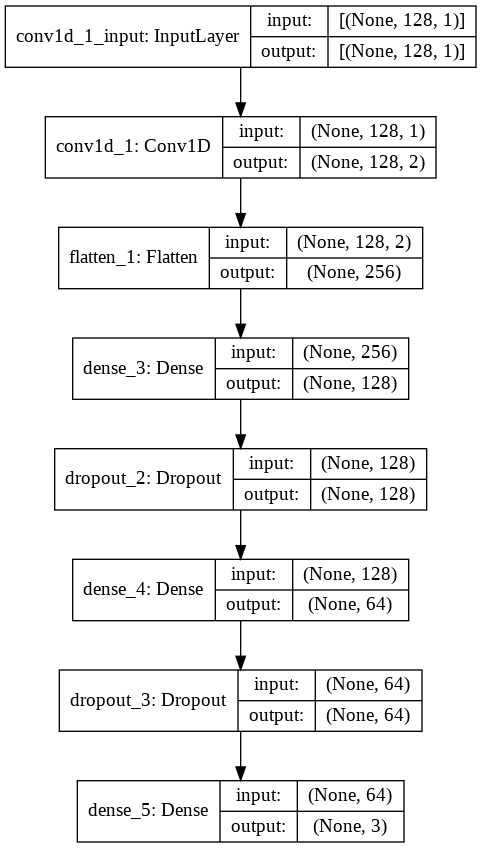

In [27]:
plot_model(model_cw_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 5.5222e-04 - mse: 5.5222e-04 - mae: 0.0183


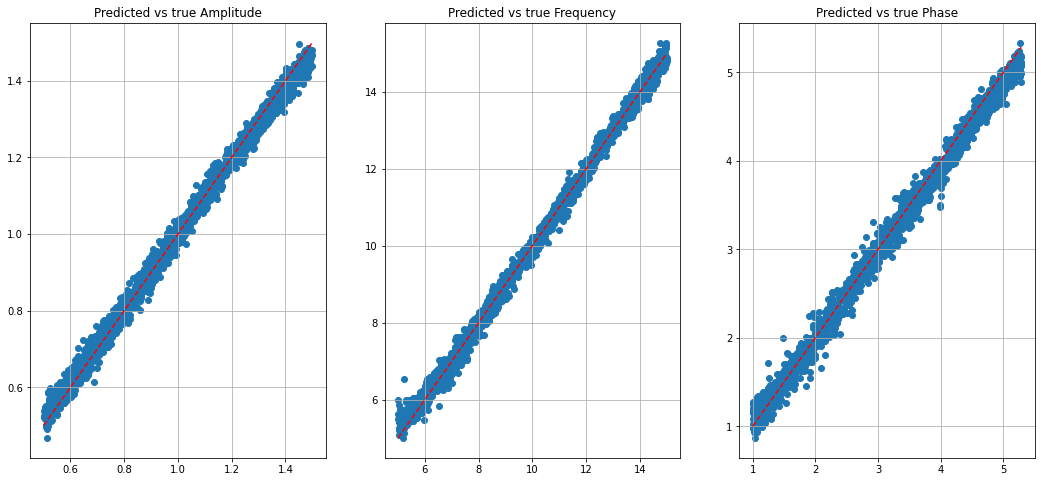

In [28]:
df_y_predict, performance = test_and_predict(model_cw_noisy, X_test, y_test)
y_test_unscaled = inverse_scale_features(y_test, scaler_iterations)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [29]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# Signal Pulse

## Helper functions

In [30]:
from scipy import signal
from scipy.fft import fft, fftshift

In [31]:
def makepulse(amp, freq, phase, samplingfreq=128, std=9, t_end=1):
  dt = 1/samplingfreq
  #t_end = samples*dt
  samples = t_end/dt
  t_array = np.arange(0, t_end, dt)
  window = signal.windows.gaussian(samples, std)
  y = amp*np.cos(2*np.pi*freq*t_array + phase) * window
  return y

## Main section

In [32]:
pulse_traces_clean = [makepulse(row[0], row[1], row[2]) for row in zip(df_iterations['Amplitude'], df_iterations['Frequency'], df_iterations['Phase'])]

### Clean

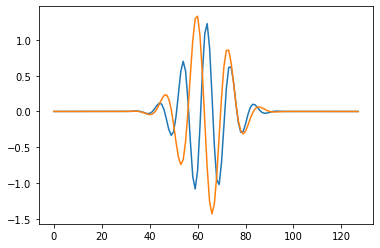

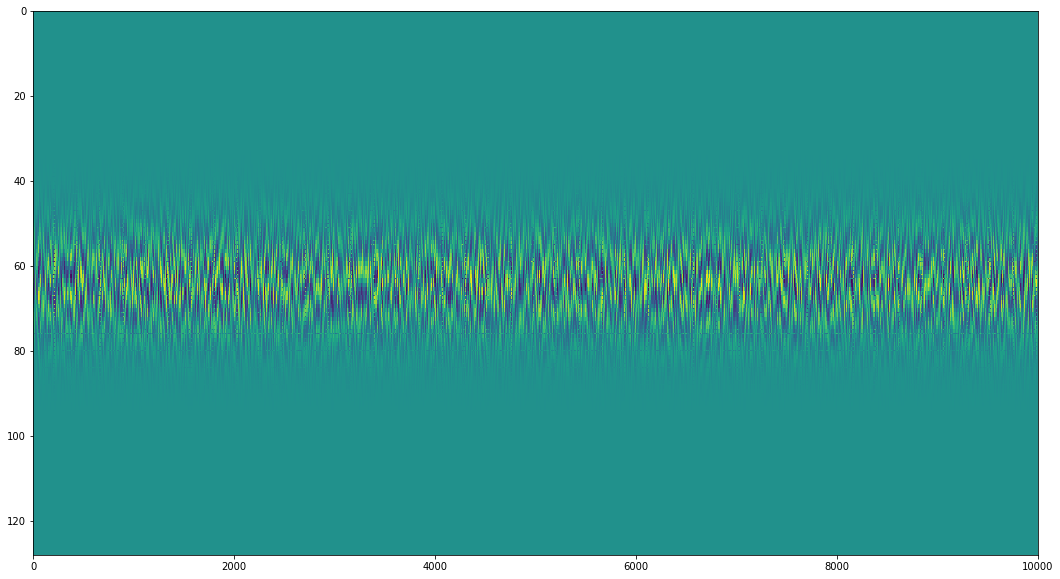

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_pulse_clean


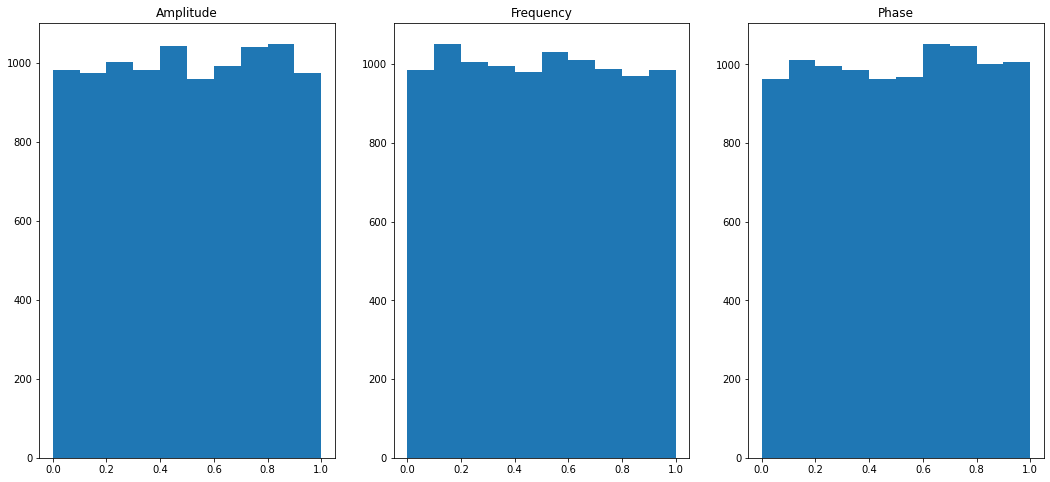

In [33]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_traces_clean, df_iterations_norm, noiseon=False)
modelname = 'model_pulse_clean'
model_pulse_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

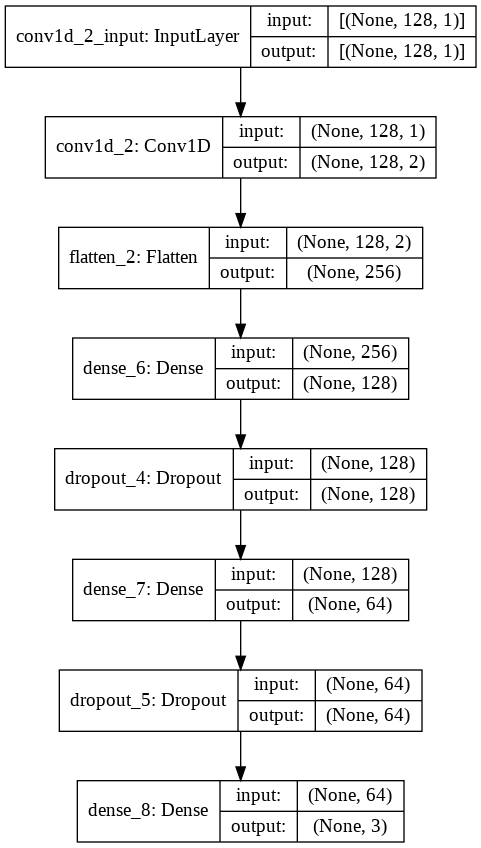

In [34]:
plot_model(model_pulse_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0229


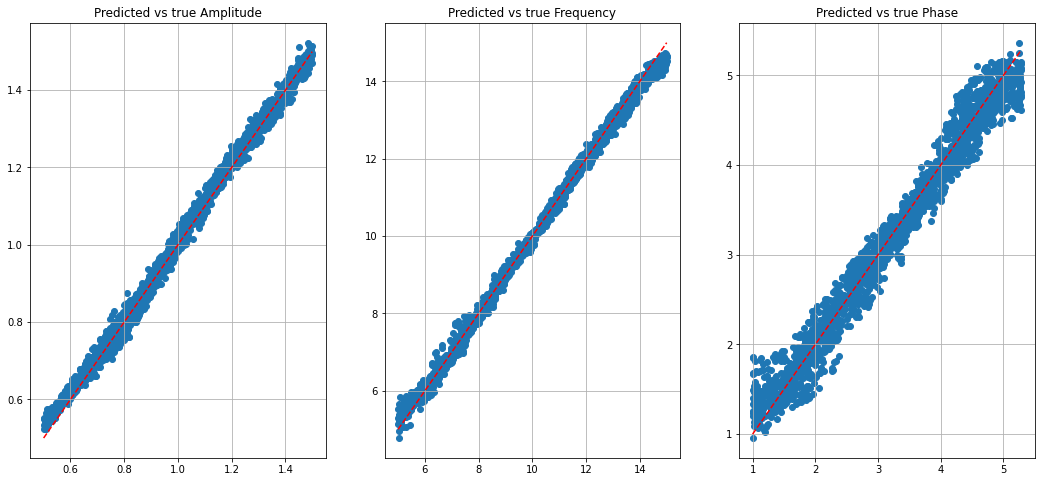

In [35]:
df_y_predict, performance = test_and_predict(model_pulse_clean, X_test, y_test)
y_test_unscaled = inverse_scale_features(y_test, scaler_iterations)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [36]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Noisy

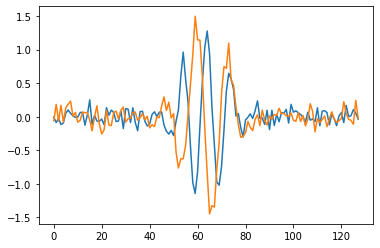

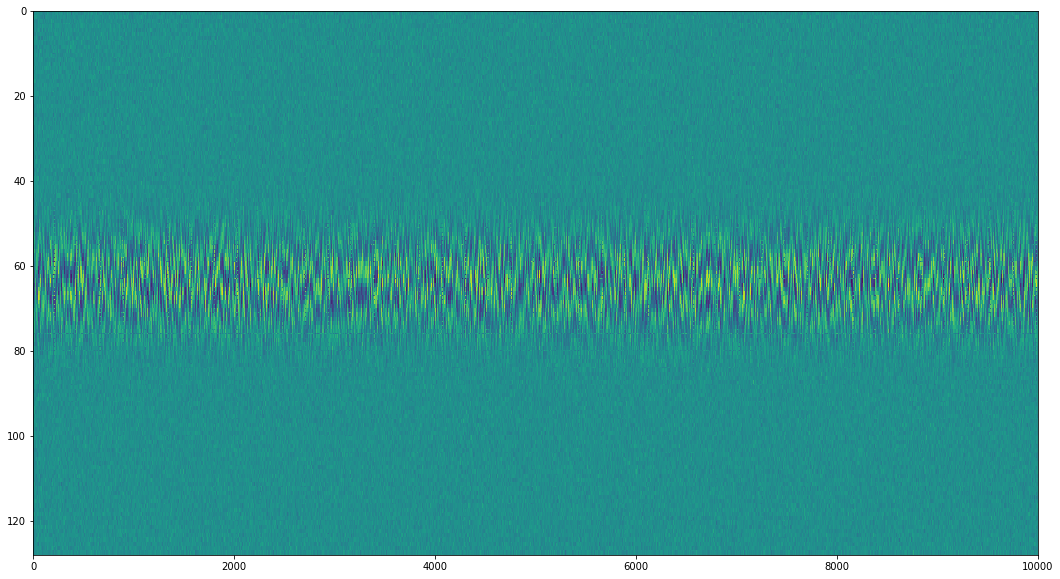

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_pulse_noisy


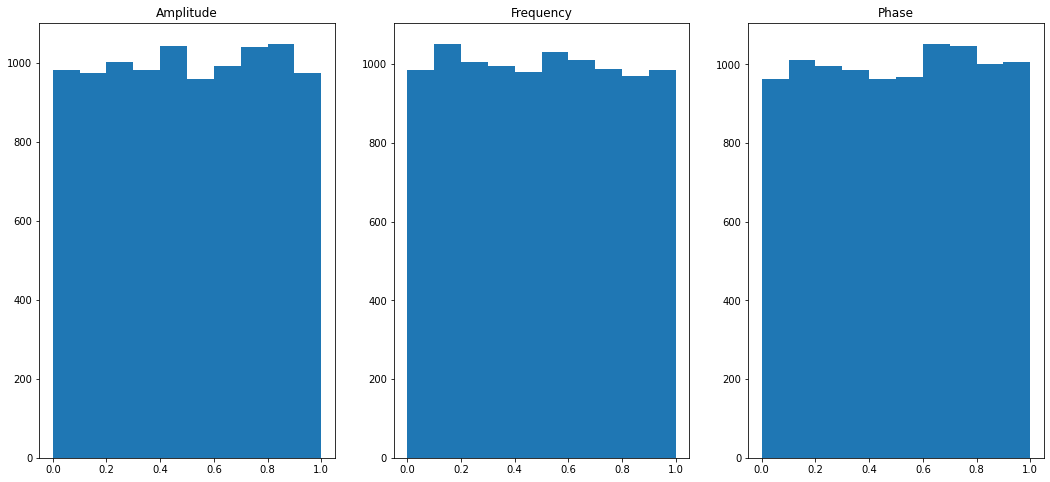

In [37]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_traces_clean, df_iterations_norm, noiseon=True)
modelname = 'model_pulse_noisy'
model_pulse_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

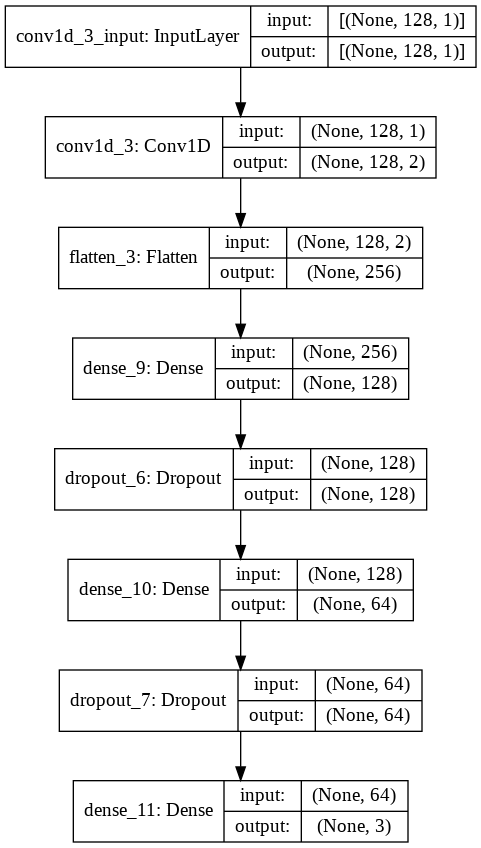

In [38]:
plot_model(model_pulse_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0772


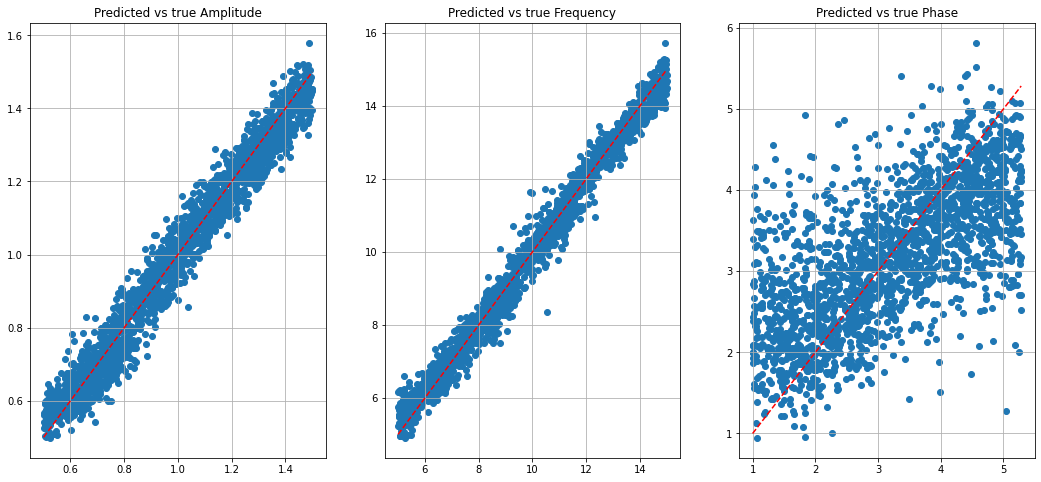

In [39]:
df_y_predict, performance = test_and_predict(model_pulse_noisy, X_test, y_test)
y_test_unscaled = inverse_scale_features(y_test, scaler_iterations)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [40]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# Pulse with timeshift


## Helper functions

In [41]:
def makepulsetimes(pulse, times, samplingfreq=128, t_end=1):
  dt = 1/samplingfreq
  samples = samplingfreq*t_end
  t_array = np.arange(0, t_end, dt)
  events = np.zeros(samples)
  #print(type(times))
  if type(times) is list:
    #print('this is a list')
    idx = [int(x / dt) for x in times]
  else: 
    idx = int(times / dt)
  events[idx] = 1
  filtered = signal.convolve(events, pulse, mode='same')
  return filtered

In [42]:
def makerandomtimeshift(n, min, max, seed=42):
  rng = np.random.default_rng(seed)
  times = rng.uniform(low=min, high=max, size=n)
  d = {'Timeshift': times}
  return pd.DataFrame(data=d)

## Main section

In [43]:
df_iterations_timeshifts = makerandomtimeshift(len(df_iterations), 0.1, 0.9)
df_iterations_w_timeshifts = df_iterations.join(df_iterations_timeshifts)

In [44]:
pulse_timeshift_traces_clean = [makepulsetimes(row[0], row[1]) for row in zip(pulse_traces_clean, df_iterations_w_timeshifts['Timeshift'])]

In [45]:
df_iterations_w_timeshifts_norm, scaler_iterations_w_timeshift = scale_features(df_iterations_w_timeshifts)

### Clean

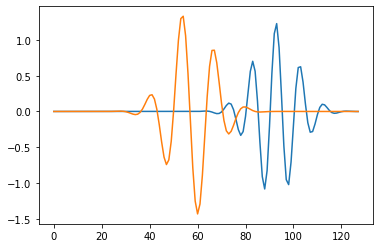

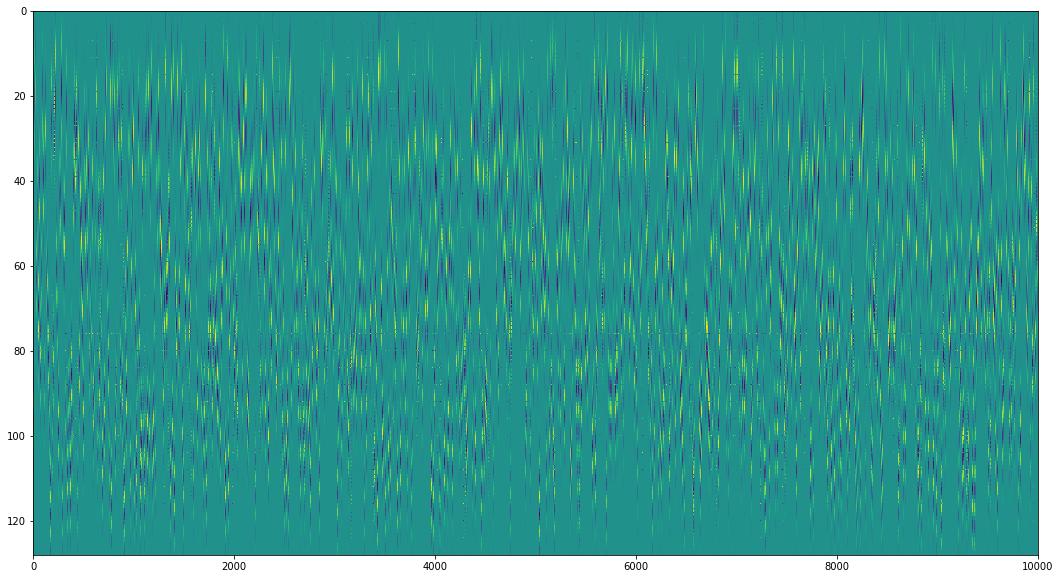

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_pulse_timeshift_clean


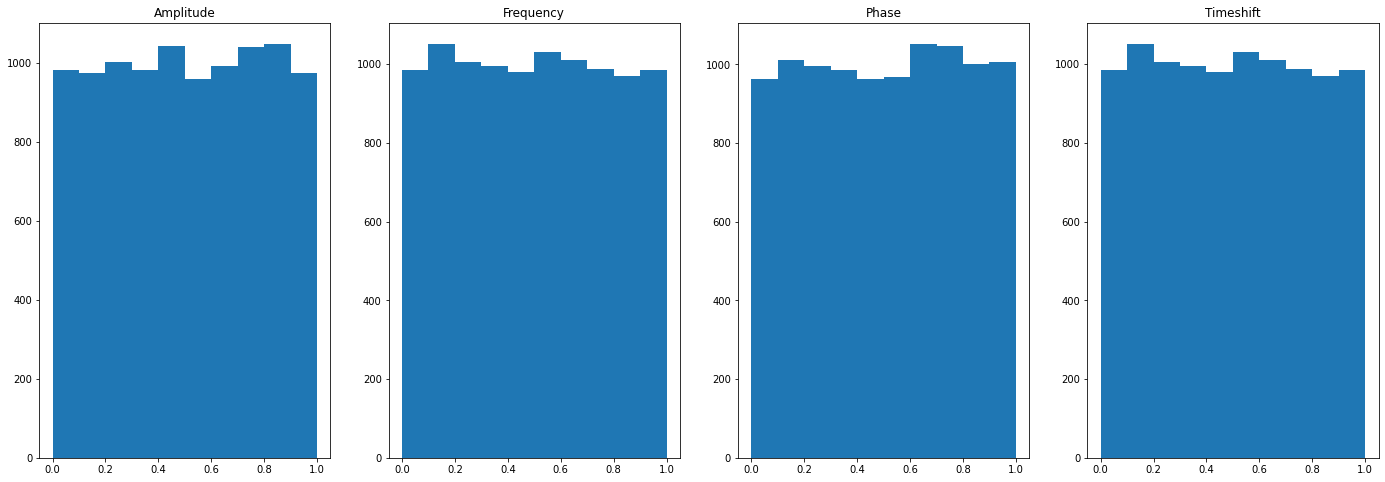

In [46]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_timeshift_traces_clean, df_iterations_w_timeshifts_norm, noiseon=False)
modelname = 'model_pulse_timeshift_clean'
model_pulse_timeshift_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

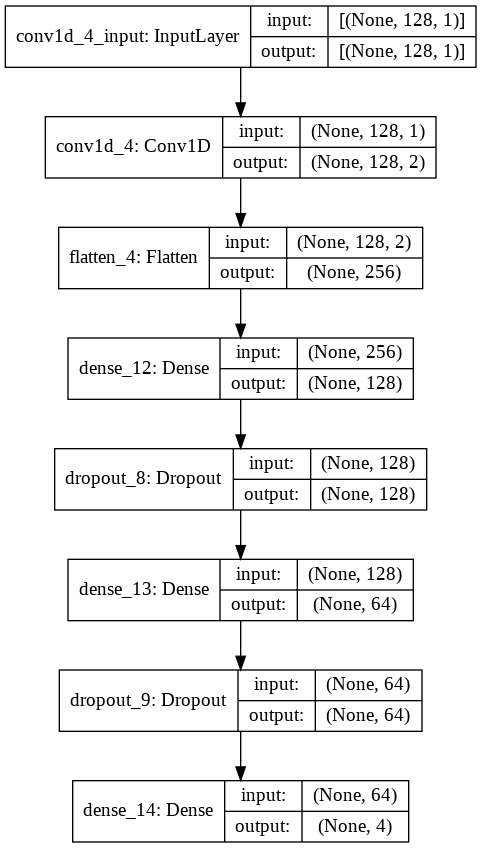

In [47]:
plot_model(model_pulse_timeshift_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 3.3056e-04 - mse: 3.3056e-04 - mae: 0.0136


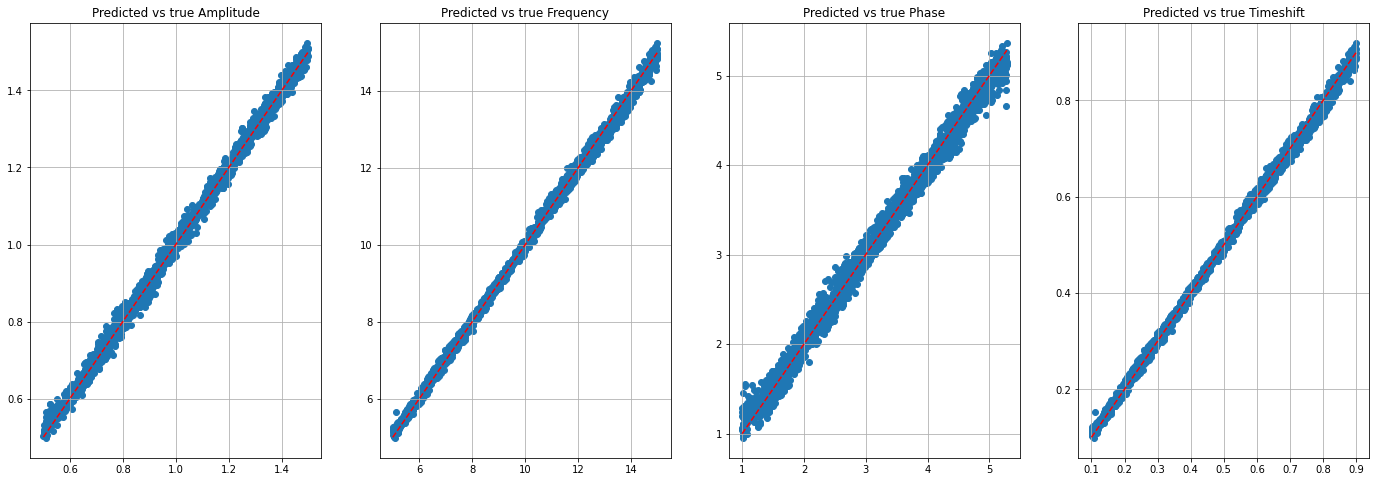

In [48]:
df_y_predict, performance = test_and_predict(model_pulse_timeshift_clean, X_test, y_test)
y_test_unscaled = inverse_scale_features(y_test, scaler_iterations_w_timeshift)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations_w_timeshift)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [49]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Noisy

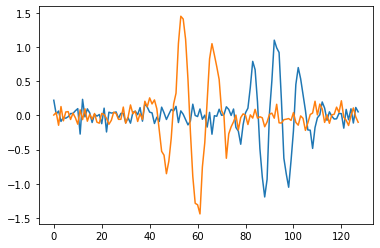

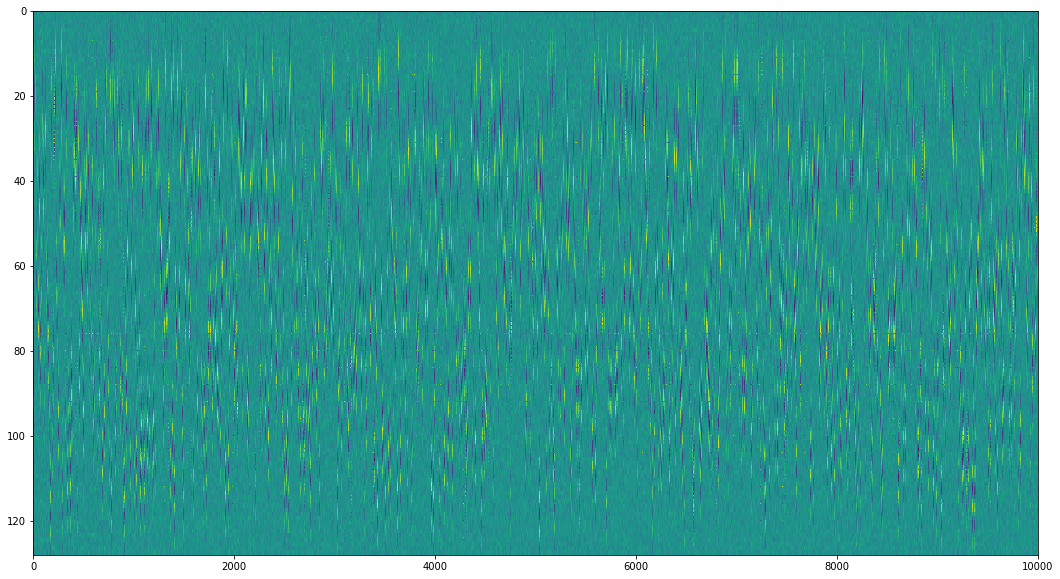

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_pulse_timeshift_noisy


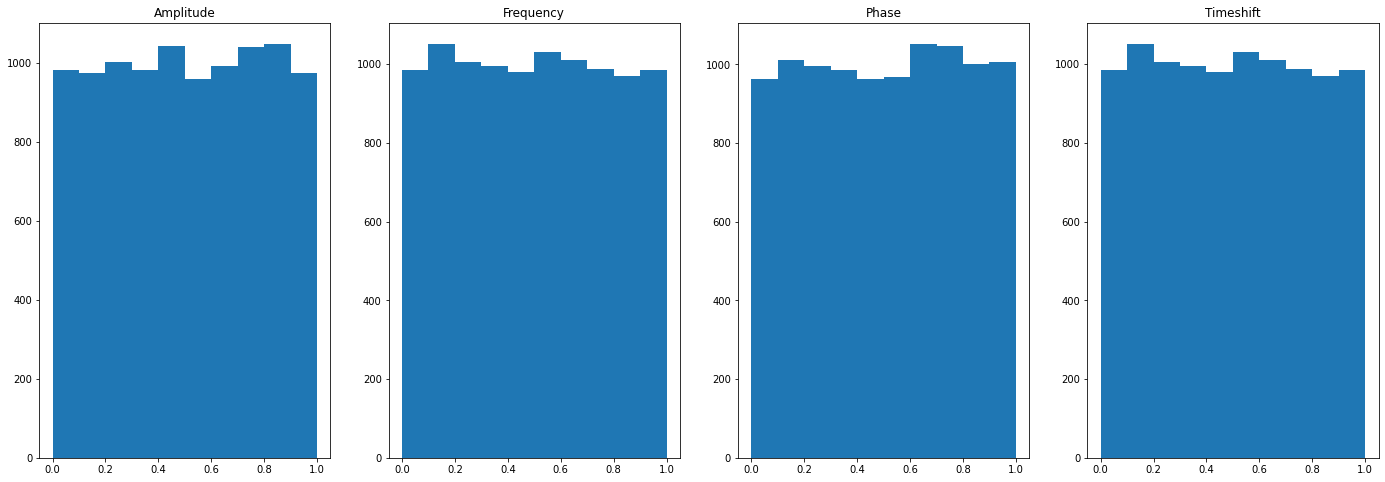

In [50]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_timeshift_traces_clean, df_iterations_w_timeshifts_norm, noiseon=True)
modelname = 'model_pulse_timeshift_noisy'
model_pulse_timeshift_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

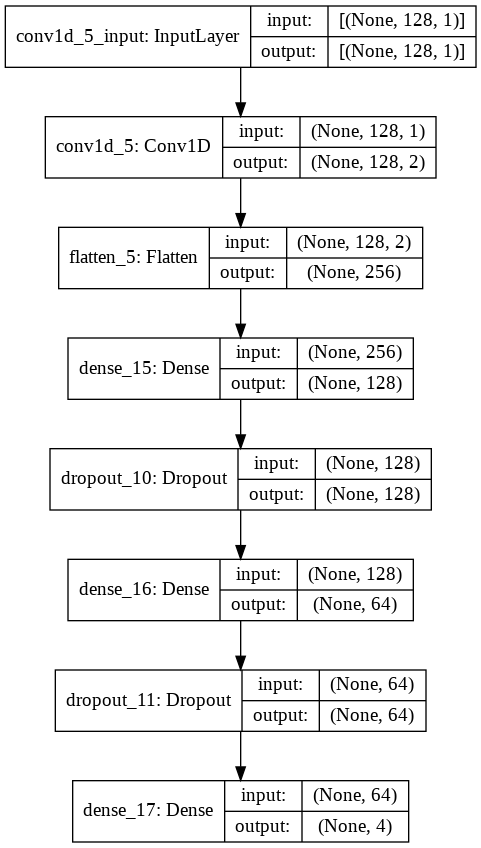

In [51]:
plot_model(model_pulse_timeshift_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0293


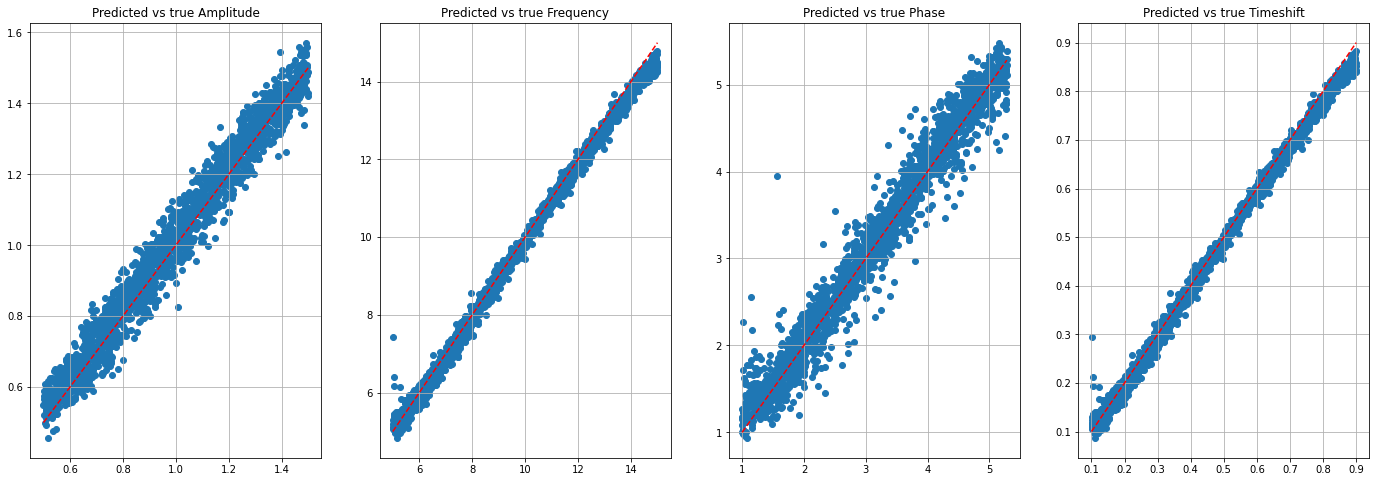

In [52]:
df_y_predict, performance = test_and_predict(model_pulse_timeshift_noisy, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler_iterations_w_timeshift)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations_w_timeshift)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [53]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# 2 Pulses with variable timeshift

## Main Section

In [54]:
df_timeshift_1 = makerandomtimeshift(dataset_size, 0.1, 0.4, seed=1)
df_timediff = makerandomtimeshift(dataset_size, 0.1, 0.5, seed=2)
df_timeshift_1.rename(columns={'Timeshift': 'Time1'}, inplace=True)
df_timediff.rename(columns={'Timeshift': 'Timediff'}, inplace=True)
df_2_pulses_timeshift_iterations = df_timeshift_1.join(df_timediff)

In [55]:
timinglist = list((df_2_pulses_timeshift_iterations['Time1'], df_2_pulses_timeshift_iterations['Time1'] + df_2_pulses_timeshift_iterations['Timediff']))
pulse_2_timeshift_traces_clean = [makepulsetimes(row[0], list((row[1], row[2]))) for row in zip(pulse_traces_clean, timinglist[0], timinglist[1])]

In [56]:
df_2_pulses_timeshift_iterations_combined = df_iterations.join(df_2_pulses_timeshift_iterations)

In [57]:
df_2_pulses_timeshift_iterations_combined_norm, scaler_2_pulses_timeshift = scale_features(df_2_pulses_timeshift_iterations_combined)

### Clean

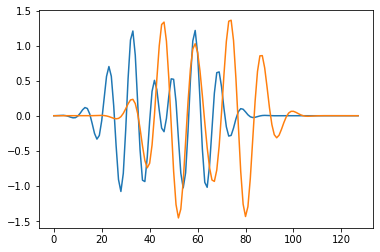

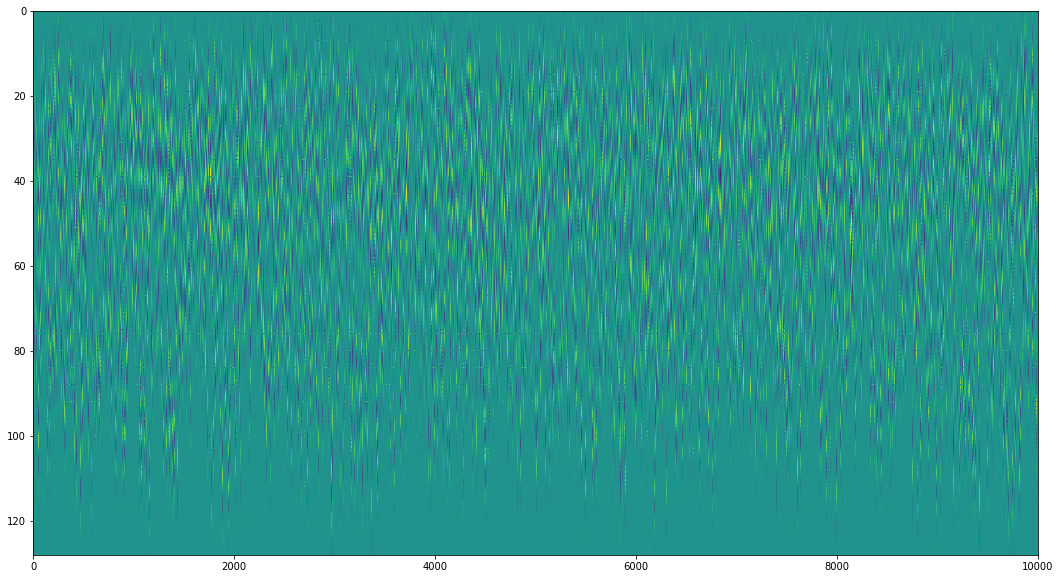

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_2_pulses_timeshift_clean


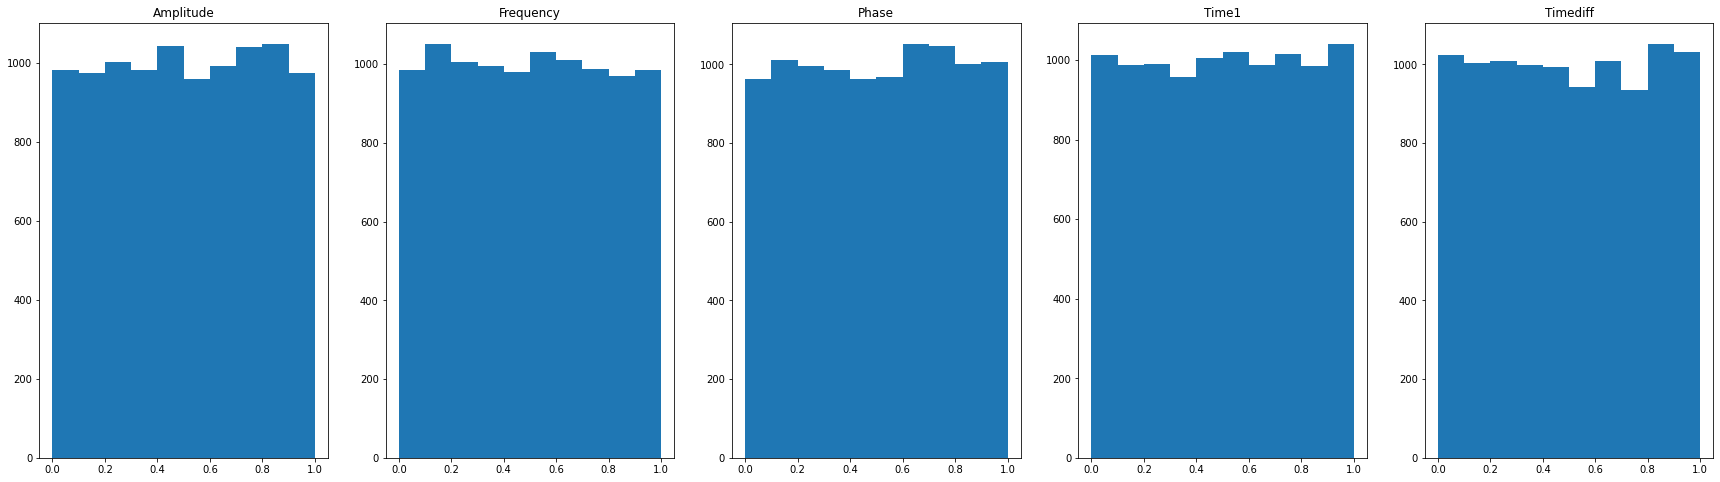

In [58]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_2_timeshift_traces_clean, df_2_pulses_timeshift_iterations_combined_norm, noiseon=False)
modelname = 'model_2_pulses_timeshift_clean'
model_2_pulses_timeshift_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

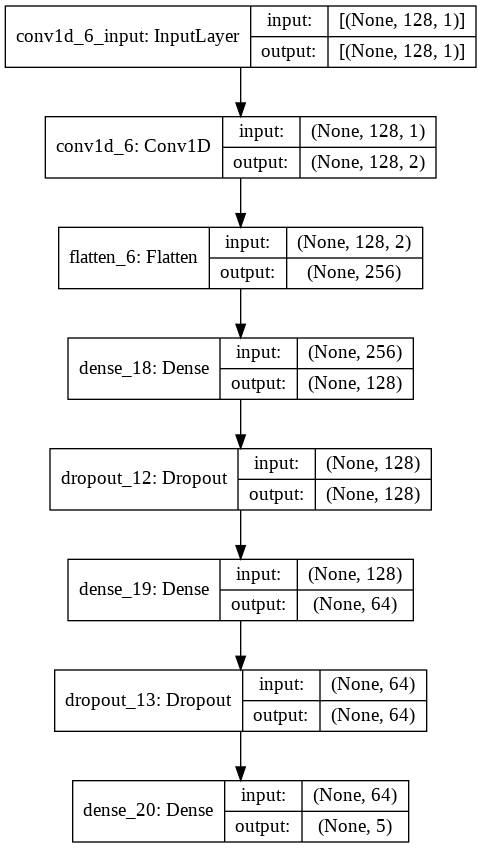

In [59]:
plot_model(model_2_pulses_timeshift_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0240 - mse: 0.0240 - mae: 0.0843


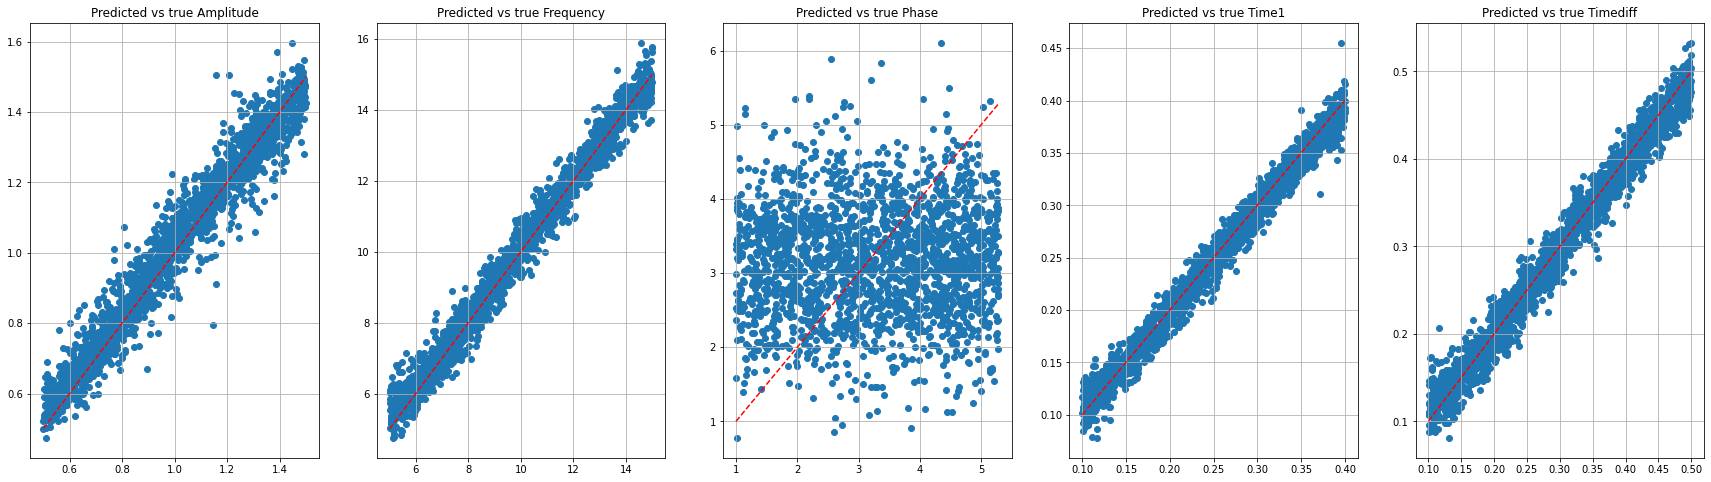

In [60]:
df_y_predict, performance = test_and_predict(model_2_pulses_timeshift_clean, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler_2_pulses_timeshift)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_2_pulses_timeshift)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [61]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Noisy

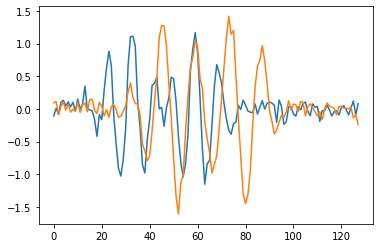

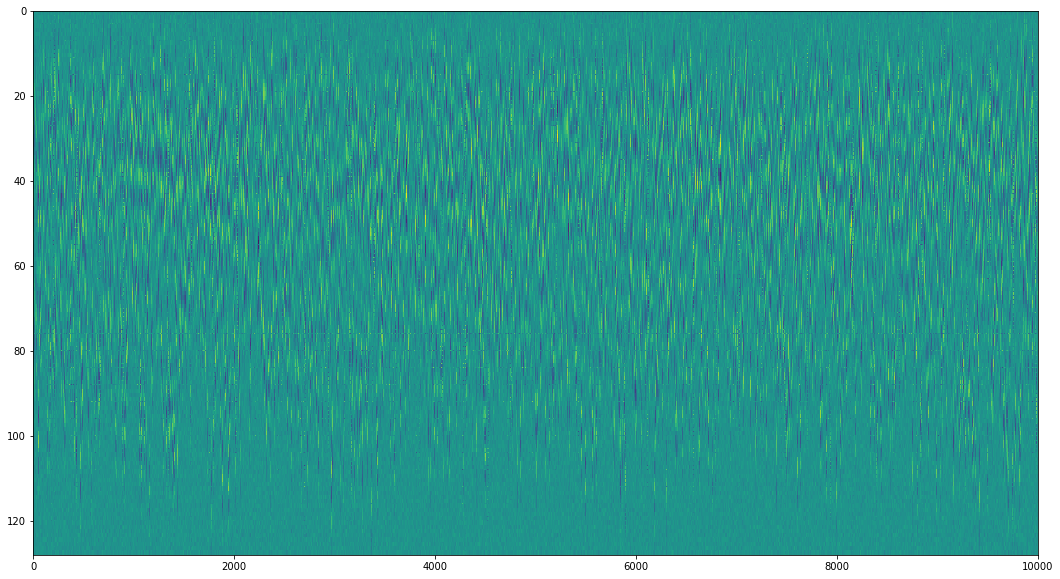

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_2_pulses_timeshift_noisy


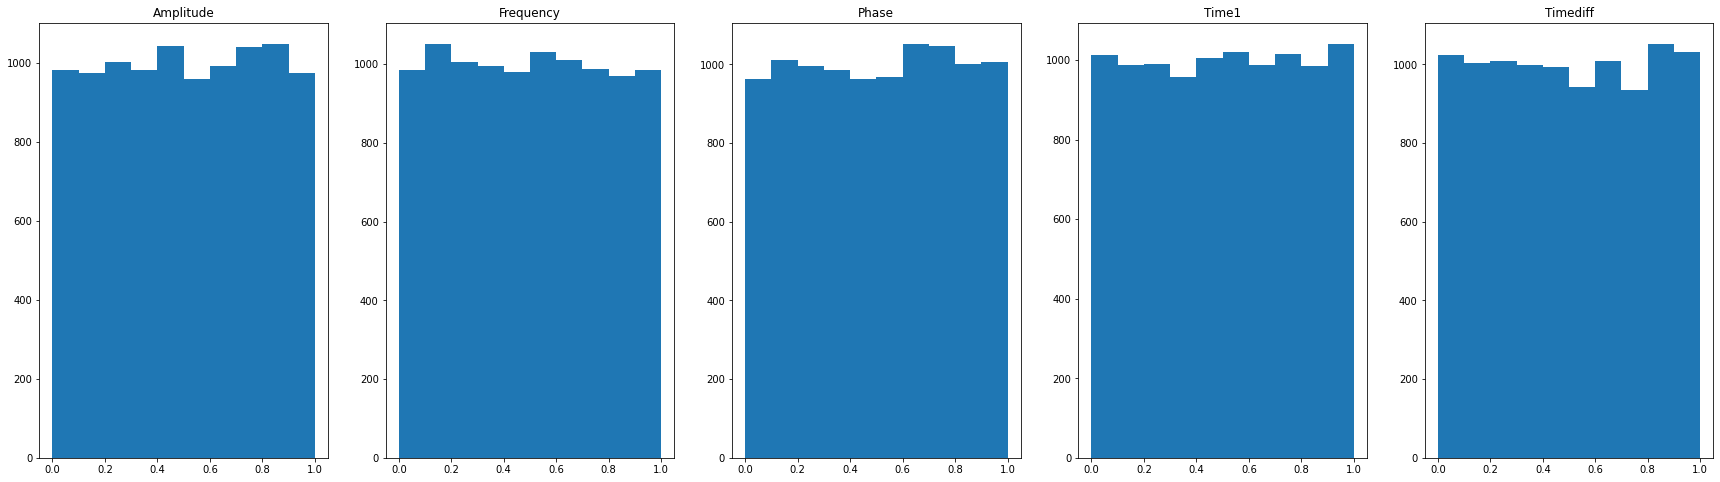

In [62]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_2_timeshift_traces_clean, df_2_pulses_timeshift_iterations_combined_norm, noiseon=True)
modelname = 'model_2_pulses_timeshift_noisy'
model_2_pulses_timeshift_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

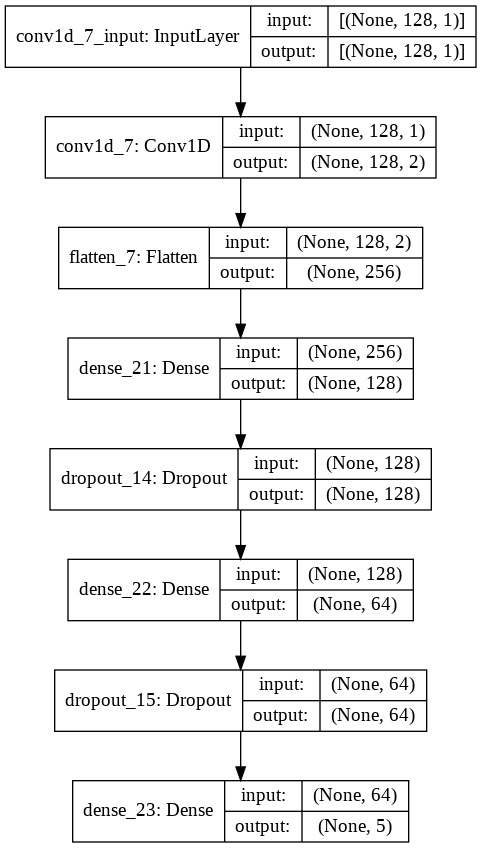

In [63]:
plot_model(model_2_pulses_timeshift_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0265 - mse: 0.0265 - mae: 0.0972


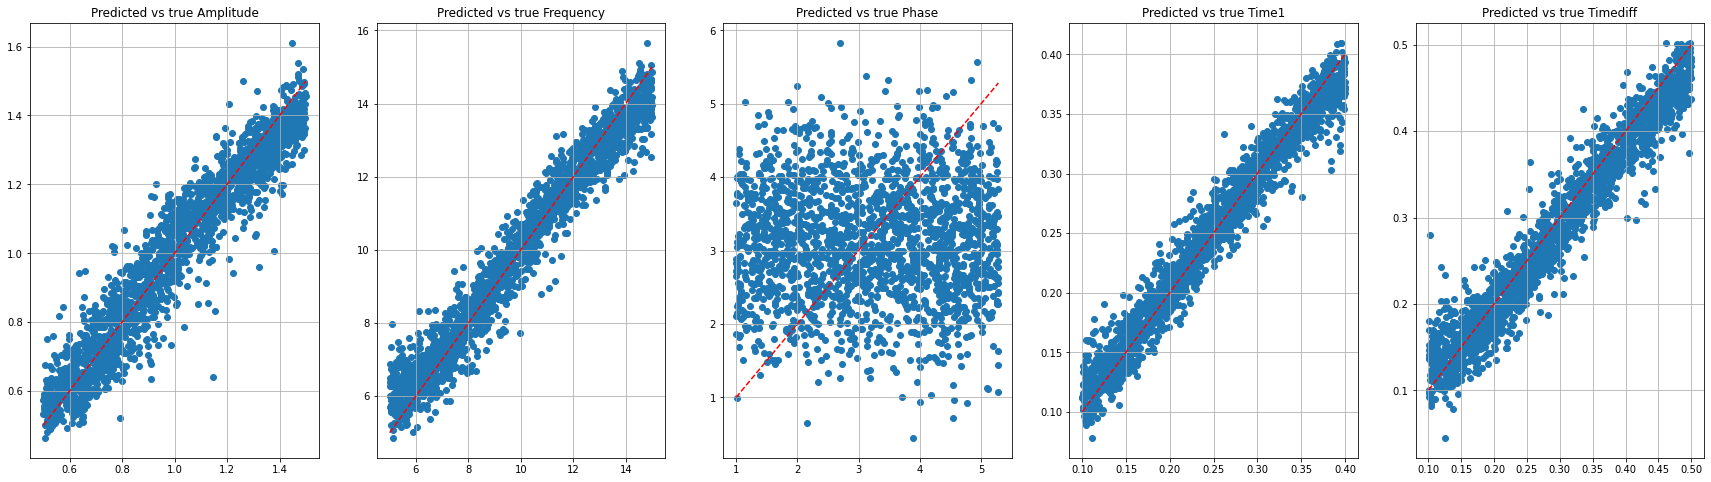

In [64]:
df_y_predict, performance = test_and_predict(model_2_pulses_timeshift_noisy, X_test, y_test)
y_test_unscaled = inverse_scale_features(y_test, scaler_2_pulses_timeshift)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_2_pulses_timeshift)
plotprediction(y_test_unscaled, df_y_predict_unscaled)


In [65]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# Interfering CW

## Main Section

In [66]:
#Amplitudes for CW2 always lower than for CW1
df_iterations_cw1 = makerandom(dataset_size, source_central_freq=10, source_mag=2, seed=11)
df_iterations_cw2 = makerandom(dataset_size, source_central_freq=10, source_mag=0.5, seed=22)
df_iterations_cw1.rename(columns={'Amplitude': 'Amplitude_1', 'Frequency': 'Frequency_1', 'Phase': 'Phase_1'}, inplace=True)
df_iterations_cw2.rename(columns={'Amplitude': 'Amplitude_2', 'Frequency': 'Frequency_2', 'Phase': 'Phase_2'}, inplace=True)
df_iterations_interfering_cw = df_iterations_cw1.join(df_iterations_cw2)

In [67]:
df_iterations_cw1

Amplitude_1  Frequency_1   Phase_1
0        1.915627     6.285702  4.272109
1        2.524241     9.992779  3.016276
2        2.520740    11.014984  3.412778
3        2.755617     5.286890  2.816742
4        1.002629     6.479261  1.009729
...           ...          ...       ...
9995     2.939430    10.757891  2.026641
9996     1.097062    11.343629  5.275544
9997     2.855560     6.544817  1.704454
9998     1.780543    14.672570  3.884685
9999     1.431949    10.618282  2.108765

[10000 rows x 3 columns]

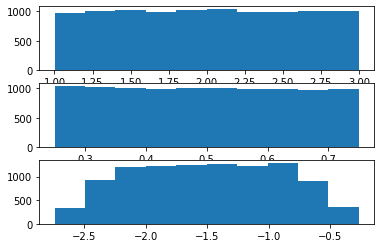

In [68]:
plt.subplot(3,1,1)
plt.hist(df_iterations_cw1['Amplitude_1'])
plt.subplot(3,1,2)
plt.hist(df_iterations_cw2['Amplitude_2'])
plt.subplot(3,1,3)
plt.hist(df_iterations_cw2['Amplitude_2']-df_iterations_cw1['Amplitude_1'])
plt.show()

In [69]:
cw1 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw1['Amplitude_1'], df_iterations_cw1['Frequency_1'], df_iterations_cw1['Phase_1'])]
cw2 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw2['Amplitude_2'], df_iterations_cw2['Frequency_2'], df_iterations_cw2['Phase_2'])]


In [70]:
cw1_plus_cw2_clean = [row[0] + row[1] for row in zip(cw1, cw2)]

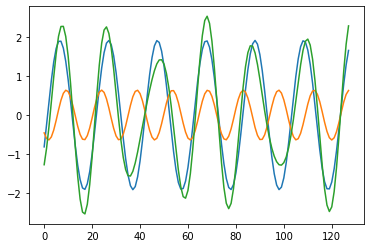

In [71]:
plt.plot(cw1[0])
plt.plot(cw2[0])
plt.plot(cw1_plus_cw2_clean[0])
plt.show()

In [72]:
df_iterations_interfering_cw_norm, scaler_interfering_cw = scale_features(df_iterations_interfering_cw)

### Clean

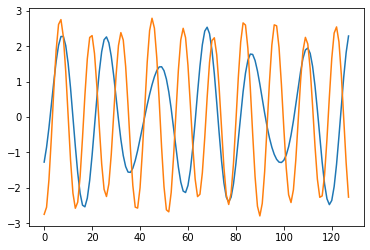

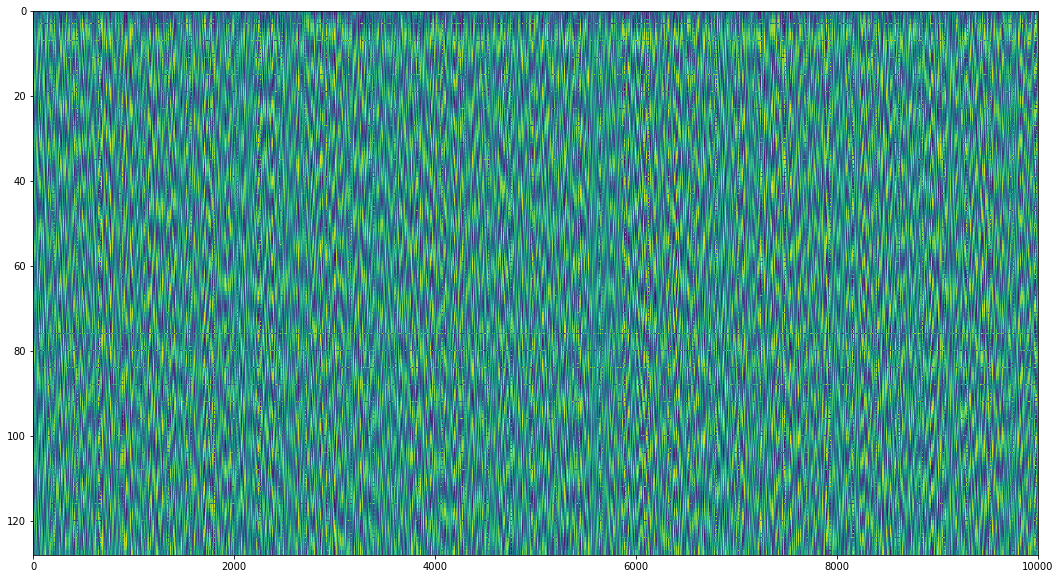

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_interfering_cw_clean


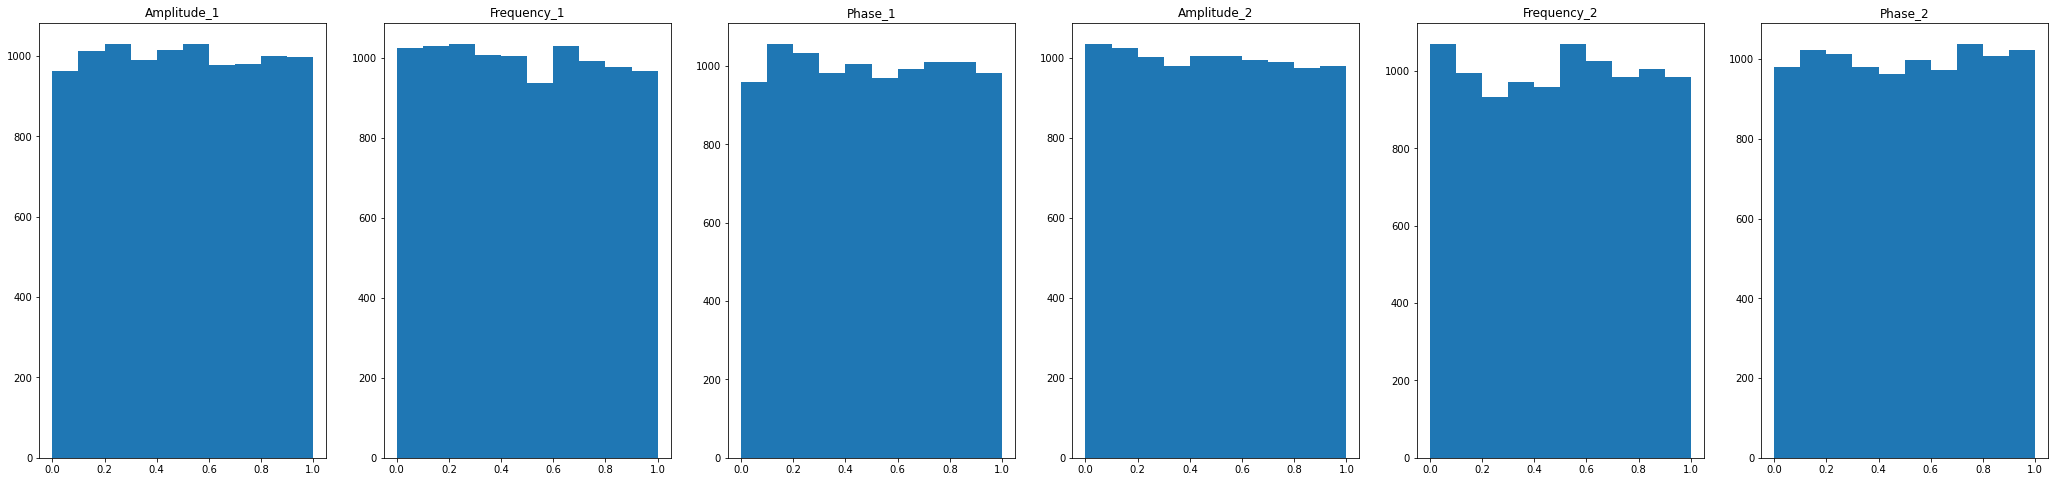

In [73]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(cw1_plus_cw2_clean, df_iterations_interfering_cw_norm, noiseon=False)
modelname = 'model_interfering_cw_clean'
model_interfering_cw_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

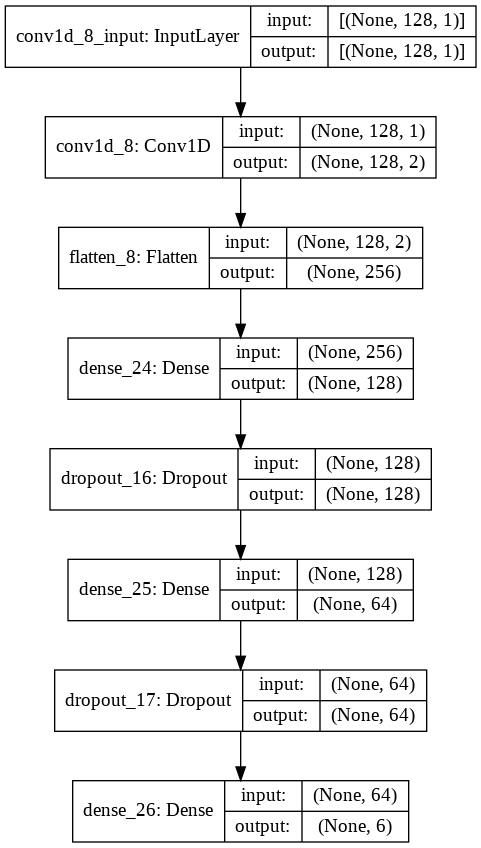

In [74]:
plot_model(model_interfering_cw_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.0979


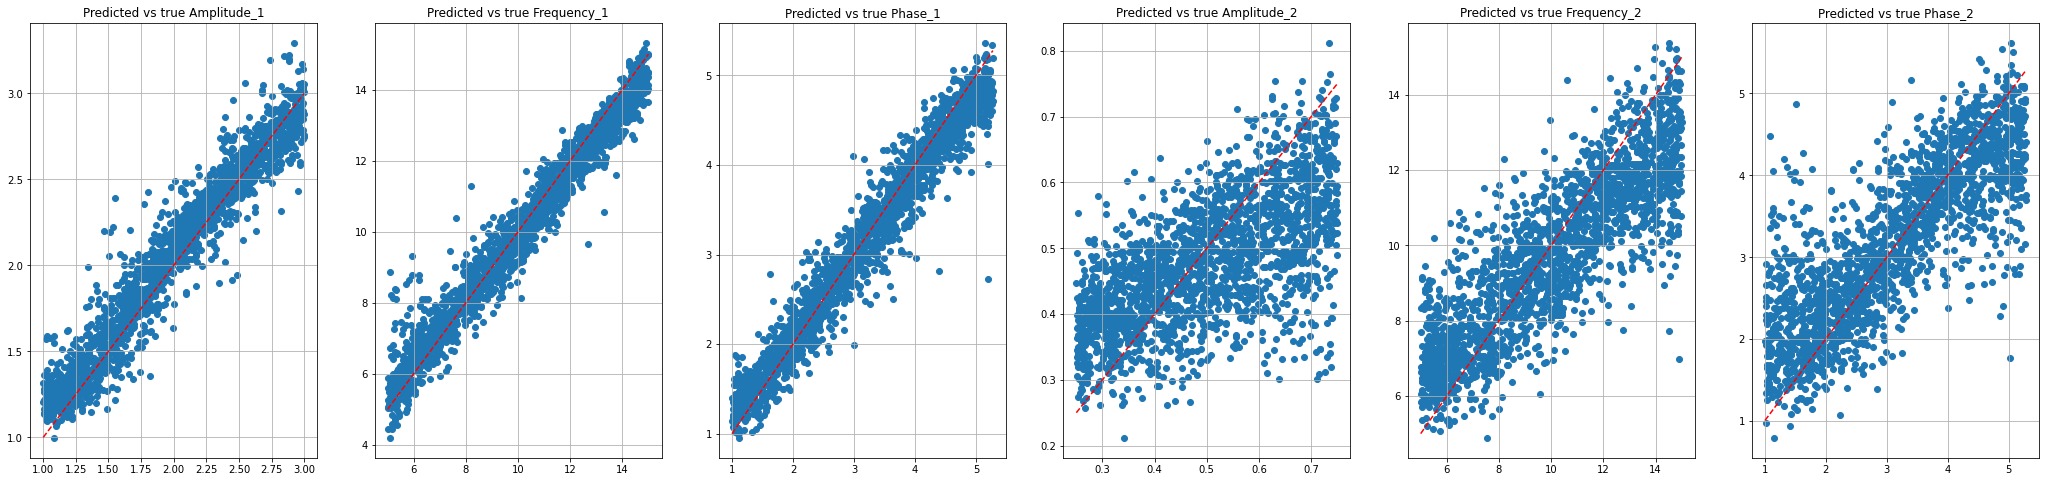

In [75]:
df_y_predict, performance = test_and_predict(model_interfering_cw_clean, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler_interfering_cw)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_interfering_cw)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [76]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Noisy

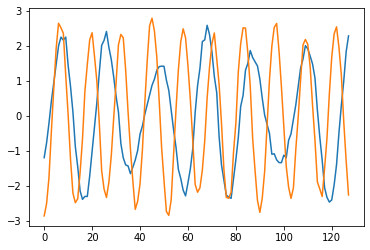

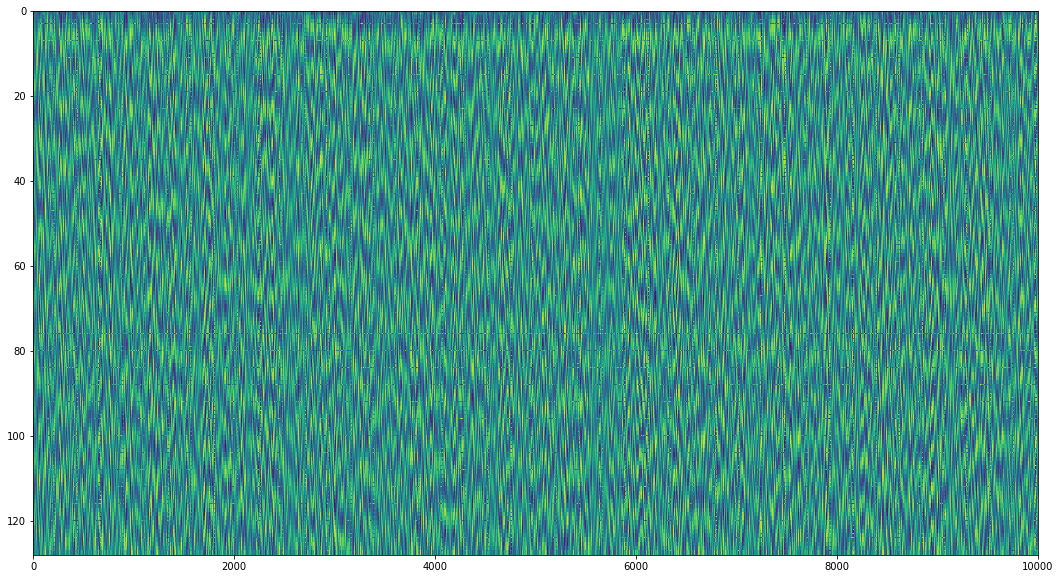

Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_interfering_cw_noisy


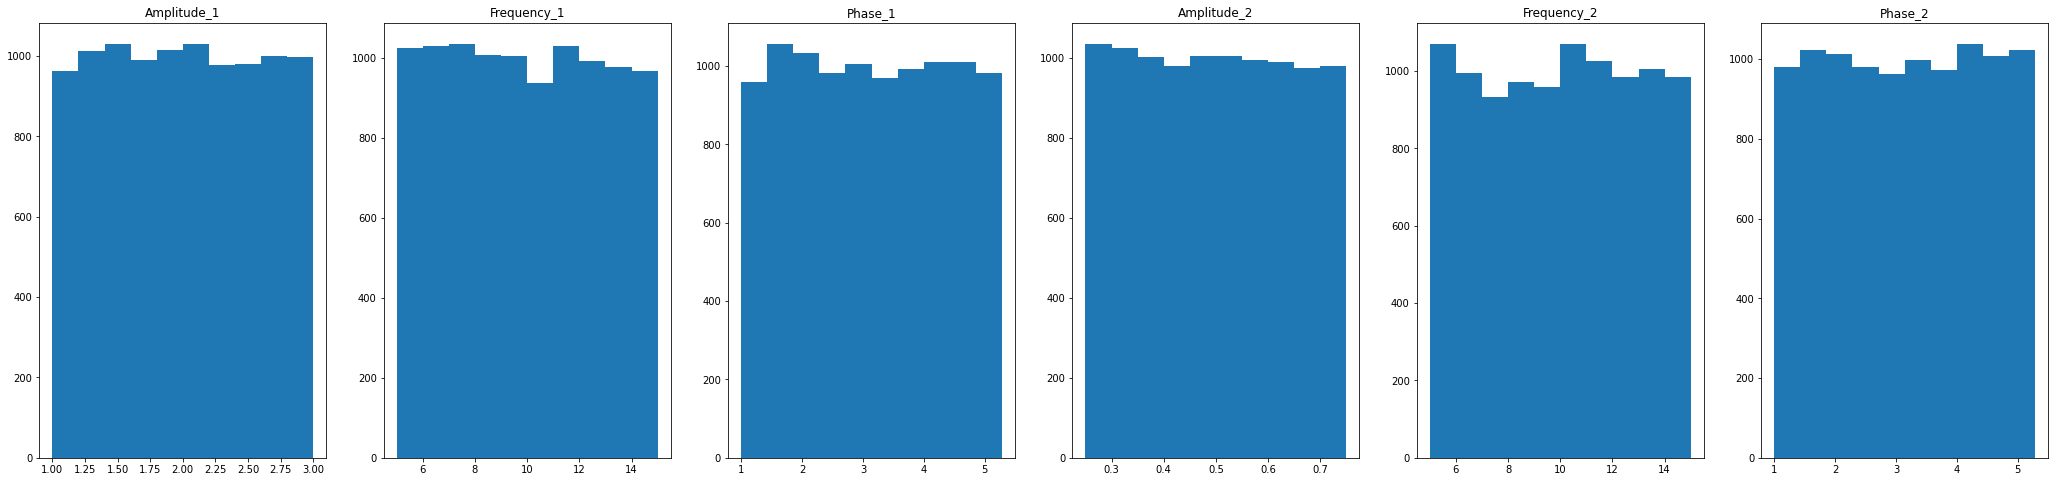

In [77]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(cw1_plus_cw2_clean, df_iterations_interfering_cw, noiseon=True)
modelname = 'model_interfering_cw_noisy'
model_interfering_cw_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models)

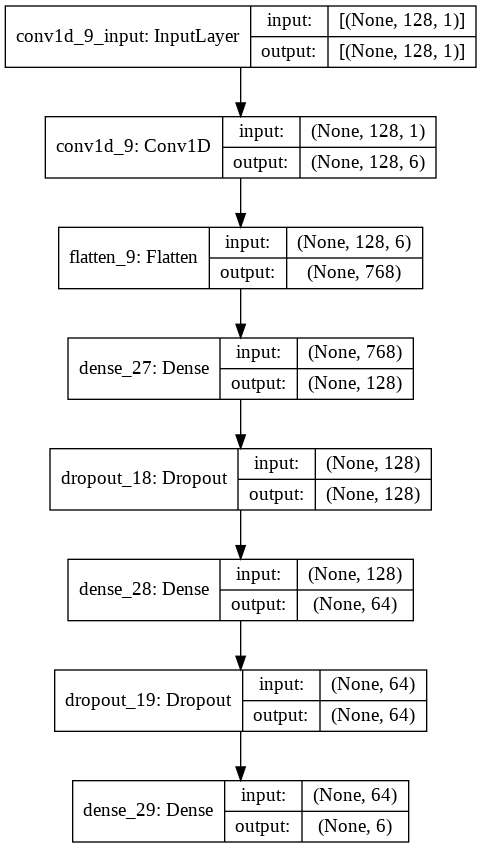

In [78]:
plot_model(model_interfering_cw_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.2778 - mse: 0.2778 - mae: 0.3255


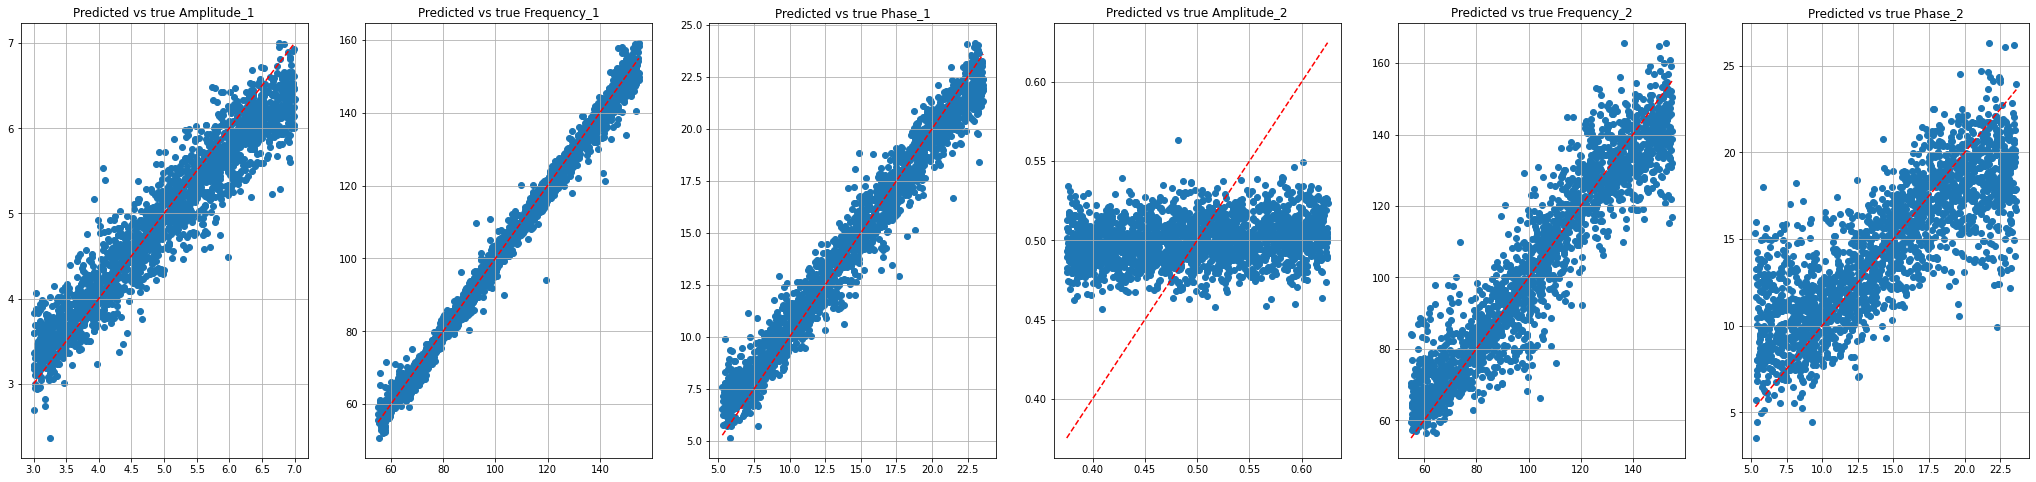

In [79]:
df_y_predict, performance = test_and_predict(model_interfering_cw_noisy, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler_interfering_cw)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_interfering_cw)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [80]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# Pre-Processing

## Helper functions

In [81]:
from scipy.signal import hilbert, correlate

In [82]:
def autocorr(array_in):
  no_traces = len(array_in)
  result = np.zeros_like(array_in)
  for i in range(0, no_traces):
    temp = np.correlate(array_in[i], array_in[i], mode='full')
    result[i] = temp[temp.size//2:]
  return result

In [83]:
def hilbert_autocorr(traces):
  traces_hilbert = abs(hilbert(traces))
  traces_autocorr = autocorr(traces)
  traces_hilbert_autocorr = autocorr(traces_hilbert)
  return np.stack((traces, traces_hilbert, traces_autocorr, traces_hilbert_autocorr), axis=-1)

In [84]:
def preprocessing_split_and_plots_2(traces_clean, df_iterations, noiseon=False, noiselevel=0.1):
  if noiseon:
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
  else:
    traces = traces_clean
  #df_traces = pd.DataFrame(traces)
  plt.plot(traces[0,:,0])
  plt.plot(traces[1,:,0])
  plt.show()
  plt.figure(figsize=(18, 10))
  #plt.pcolormesh(df_traces.T)
  #plt.gca().invert_yaxis()
  #plt.show()

  plot_hists(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(traces, df_iterations, test_size=0.2, random_state=42)
  #X_train = np.expand_dims(X_train, axis=2)
  print(X_train.shape, y_train.shape)
  return X_train, X_test, y_train, y_test

## Envelope Detection and Autocorrelation

Datasets:



1.   traces_clean - Probably no benefit since CW (envelope or autocorr has no meaning)
2.   pulse_traces_clean
3.   pulse_timeshift_traces_clean
4.   pulse_2_timeshift_traces_clean
5.   model_interfering_cw_clean






### Continous Wave - Not needed

In [85]:
#traces_clean_hilbert_autocorr = hilbert_autocorr(traces_clean)

In [86]:
'''X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(traces_clean_hilbert_autocorr, df_iterations, noiseon=False)
modelname = 'model_cw_clean_hilbert_autocorr'
model_cw_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)
'''

"X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(traces_clean_hilbert_autocorr, df_iterations, noiseon=False)\nmodelname = 'model_cw_clean_hilbert_autocorr'\nmodel_cw_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)\n"

In [87]:
#plot_model(model_cw_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

In [88]:
#df_y_predict, performance = test_and_predict(model_cw_clean_hilbert_autocorr, X_test, y_test)
#plotprediction(y_test, df_y_predict)

In [89]:
#df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Signal Pulse

In [90]:
pulse_traces_clean_hilbert_autocorr = hilbert_autocorr(pulse_traces_clean)

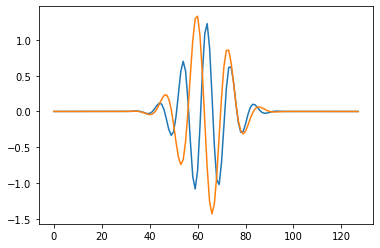

(8000, 128, 4) (8000, 3)
Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_pulse_clean_hilbert_autocorr


<Figure size 1296x720 with 0 Axes>

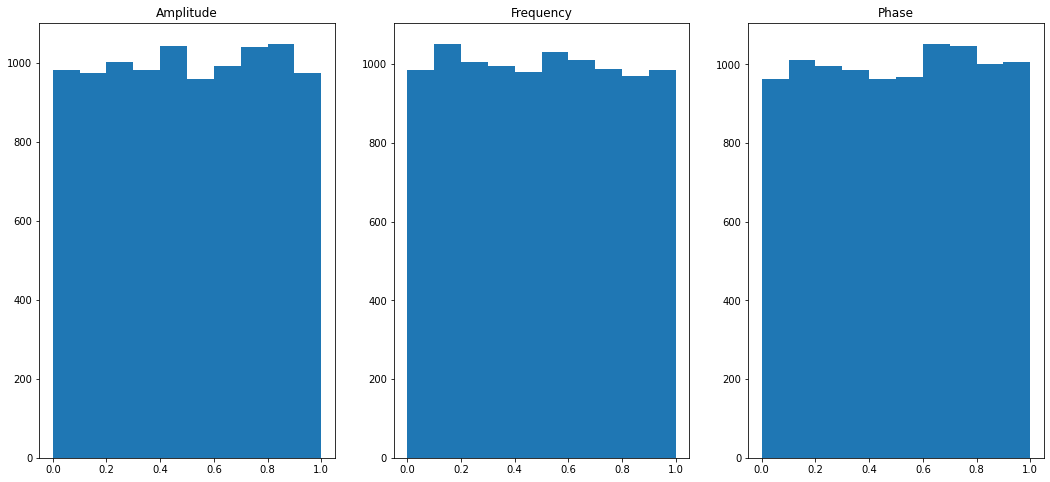

In [91]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_traces_clean_hilbert_autocorr, df_iterations_norm, noiseon=False)
modelname = 'model_pulse_clean_hilbert_autocorr'
model_pulse_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

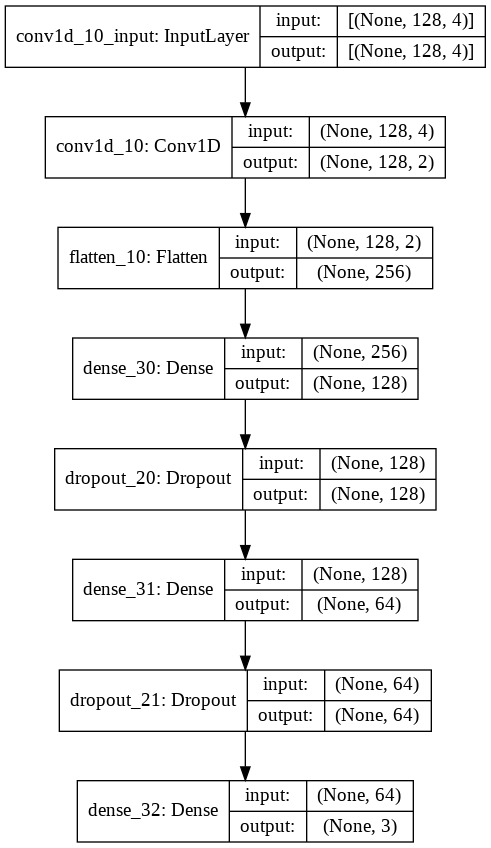

In [92]:
plot_model(model_pulse_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 4.4329e-04 - mse: 4.4329e-04 - mae: 0.0160


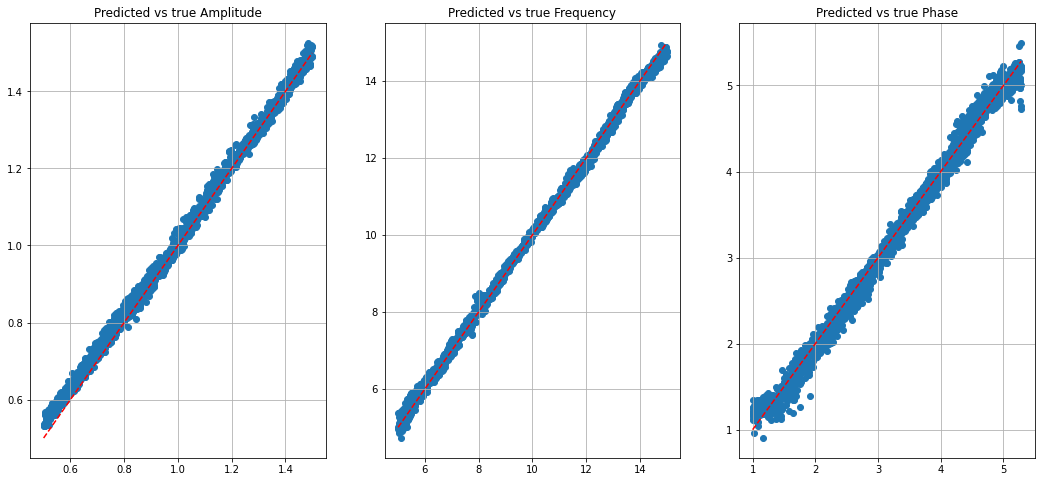

In [93]:
df_y_predict, performance = test_and_predict(model_pulse_clean_hilbert_autocorr, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler_iterations)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [94]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

In [95]:
def add_noise(traces_clean, noiselevel=0.1):
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
    return traces

In [96]:
pulse_traces_noisy = add_noise(pulse_traces_clean)

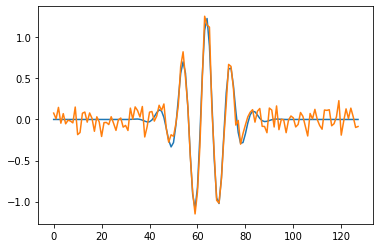

In [97]:
plt.plot(pulse_traces_clean[0])
plt.plot(pulse_traces_noisy[0])
plt.show()

In [98]:
pulse_traces_noisy_hilbert_autocorr = hilbert_autocorr(pulse_traces_noisy)

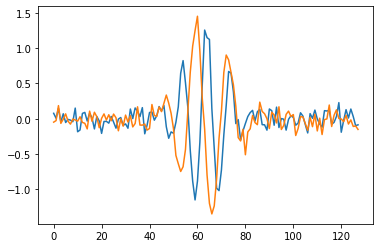

(8000, 128, 4) (8000, 3)
Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_pulse_noisy_hilbert_autocorr


<Figure size 1296x720 with 0 Axes>

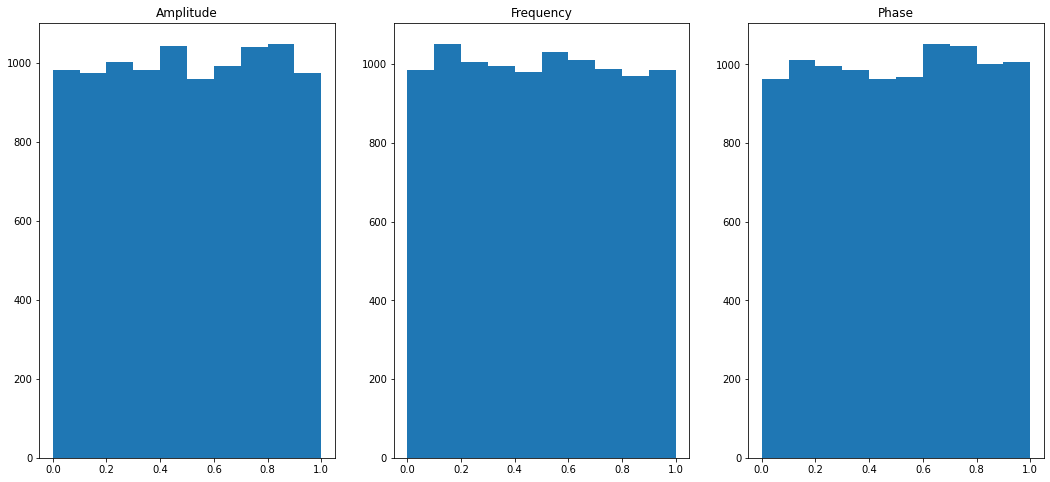

In [99]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_traces_noisy_hilbert_autocorr, df_iterations_norm, noiseon=False) # noiseon=False since noise is alreay added.
modelname = 'model_pulse_noisy_hilbert_autocorr'
model_pulse_noisy_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

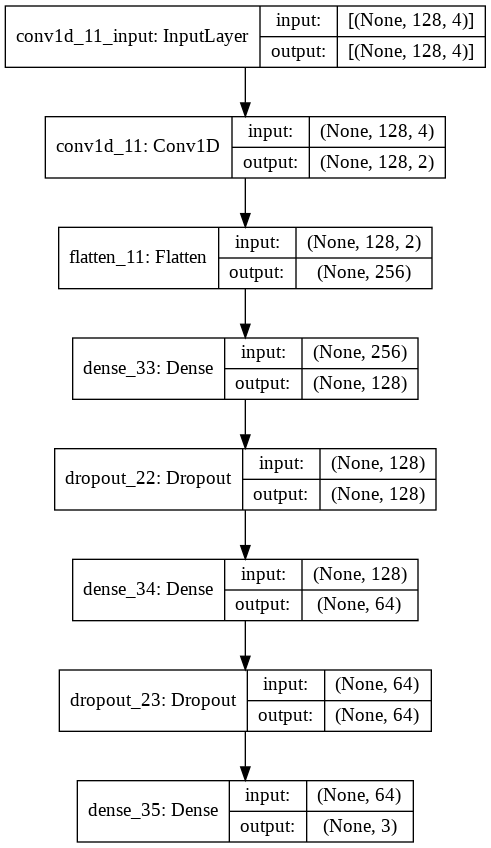

In [100]:
plot_model(model_pulse_noisy_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0575


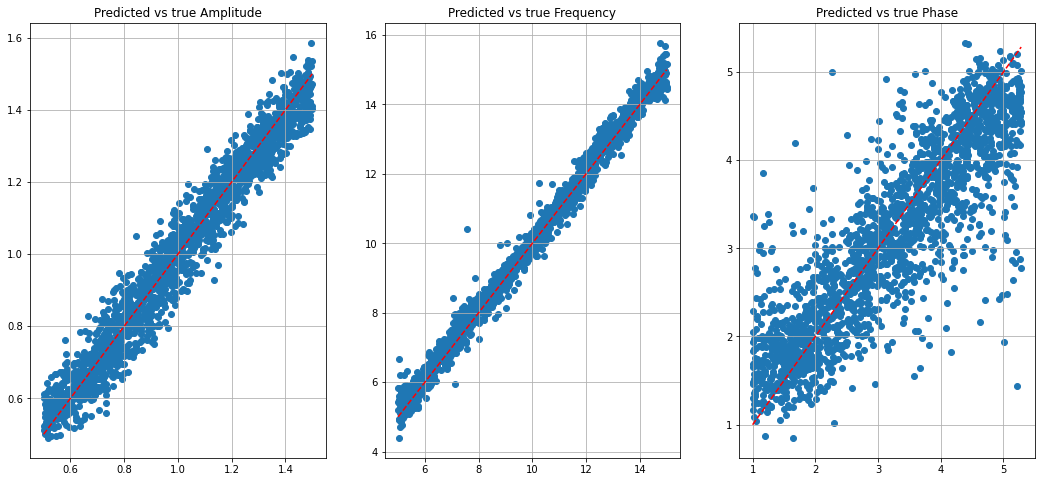

In [101]:
df_y_predict, performance = test_and_predict(model_pulse_noisy_hilbert_autocorr, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler_iterations)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [102]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Pulse with Timeshift

In [103]:
pulse_timeshift_traces_clean_hilbert_autocorr = hilbert_autocorr(pulse_timeshift_traces_clean)

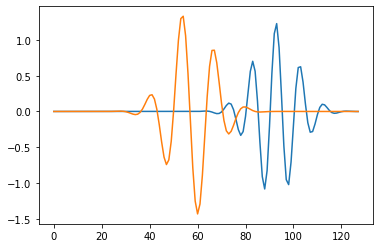

(8000, 128, 4) (8000, 4)
Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_pulse_timeshift_clean_hilbert_autocorr


<Figure size 1296x720 with 0 Axes>

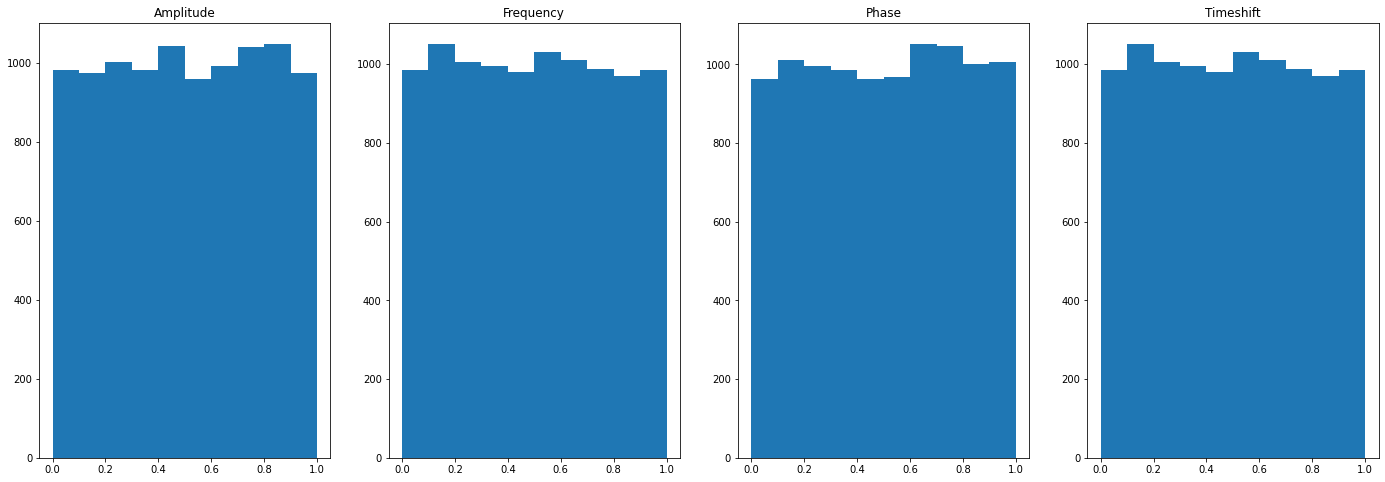

In [104]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_timeshift_traces_clean_hilbert_autocorr, df_iterations_w_timeshifts_norm, noiseon=False)
modelname = 'model_pulse_timeshift_clean_hilbert_autocorr'
model_pulse_timeshift_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

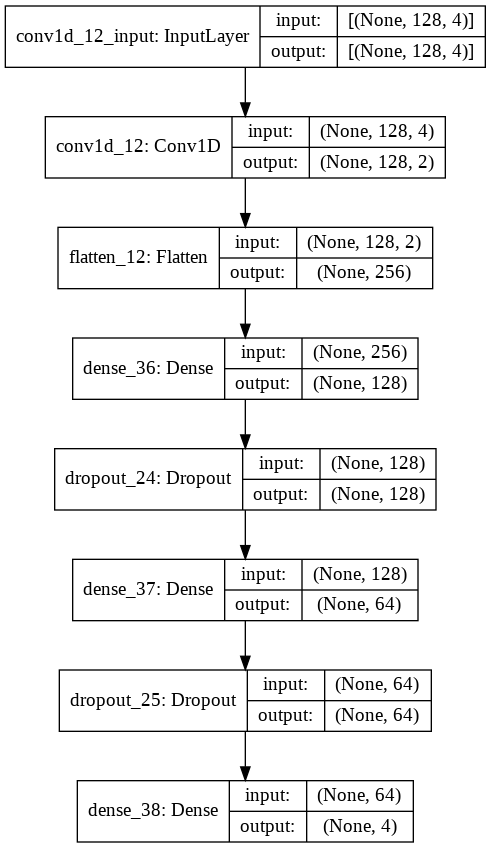

In [105]:
plot_model(model_pulse_timeshift_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 4.9061e-04 - mse: 4.9061e-04 - mae: 0.0165


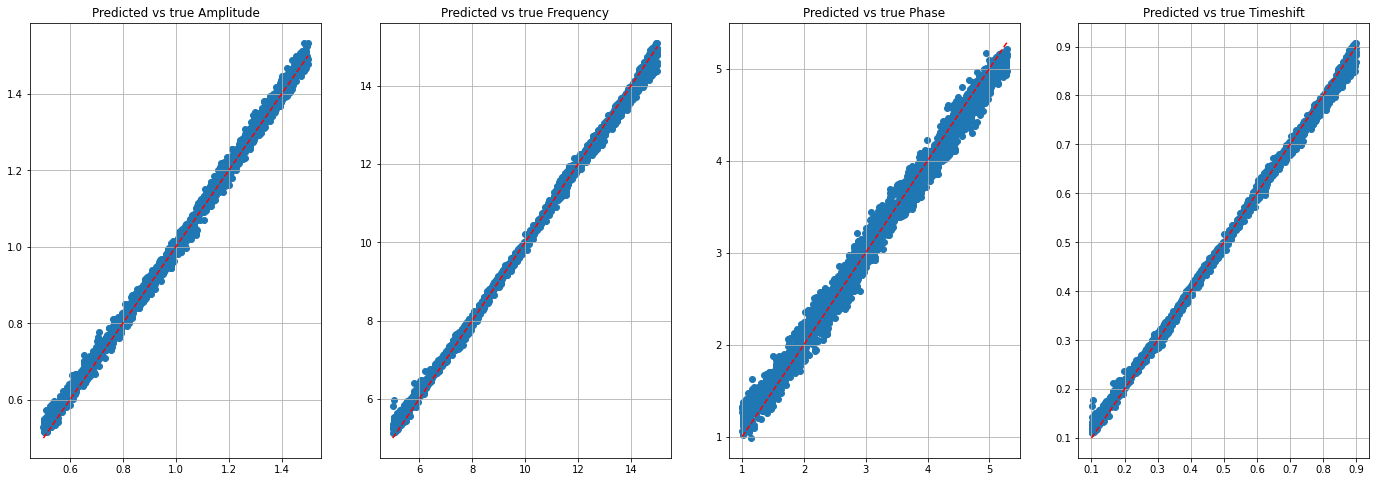

In [106]:
df_y_predict, performance = test_and_predict(model_pulse_timeshift_clean_hilbert_autocorr, X_test, y_test)
y_test_unscaled = inverse_scale_features(y_test, scaler_iterations_w_timeshift)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations_w_timeshift)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [107]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Noisy

In [108]:
pulse_timeshift_traces_noisy = add_noise(pulse_timeshift_traces_clean)
pulse_timeshift_traces_noisy_hilbert_autocorr = hilbert_autocorr(pulse_timeshift_traces_noisy)

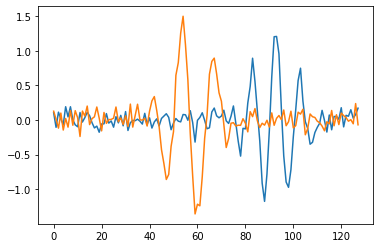

(8000, 128, 4) (8000, 4)
Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_pulse_timeshift_noisy_hilbert_autocorr


<Figure size 1296x720 with 0 Axes>

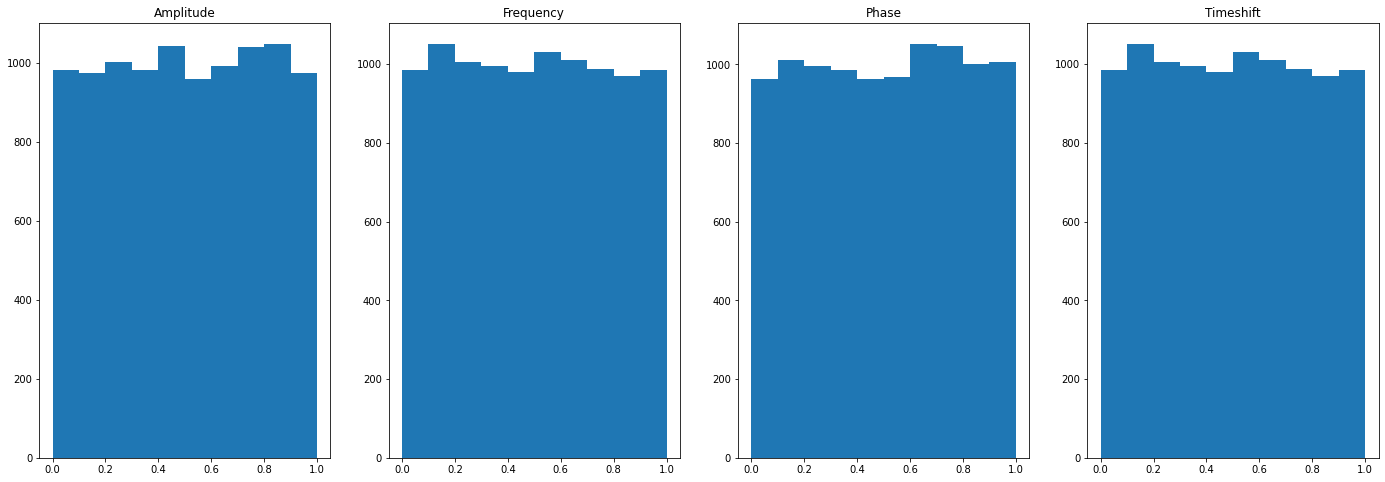

In [109]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_timeshift_traces_noisy_hilbert_autocorr, df_iterations_w_timeshifts_norm, noiseon=False) #Noise already added, so noison=False
modelname = 'model_pulse_timeshift_noisy_hilbert_autocorr'
model_pulse_timeshift_noisy_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

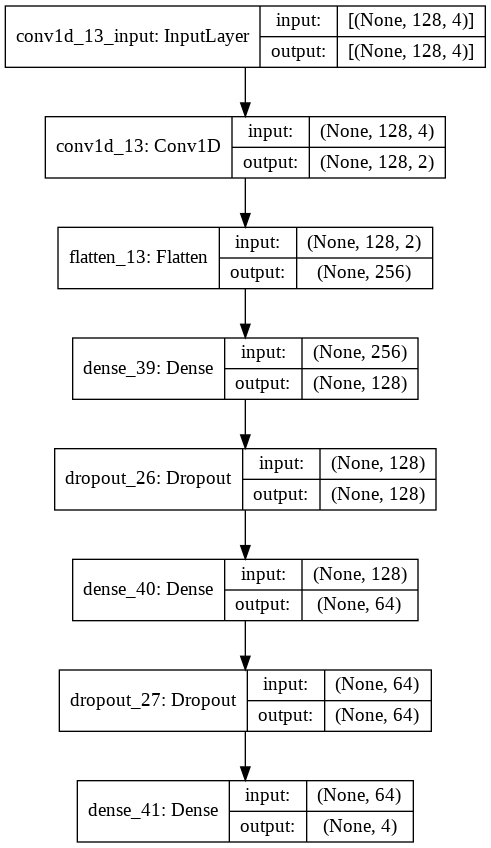

In [110]:
plot_model(model_pulse_timeshift_noisy_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0251


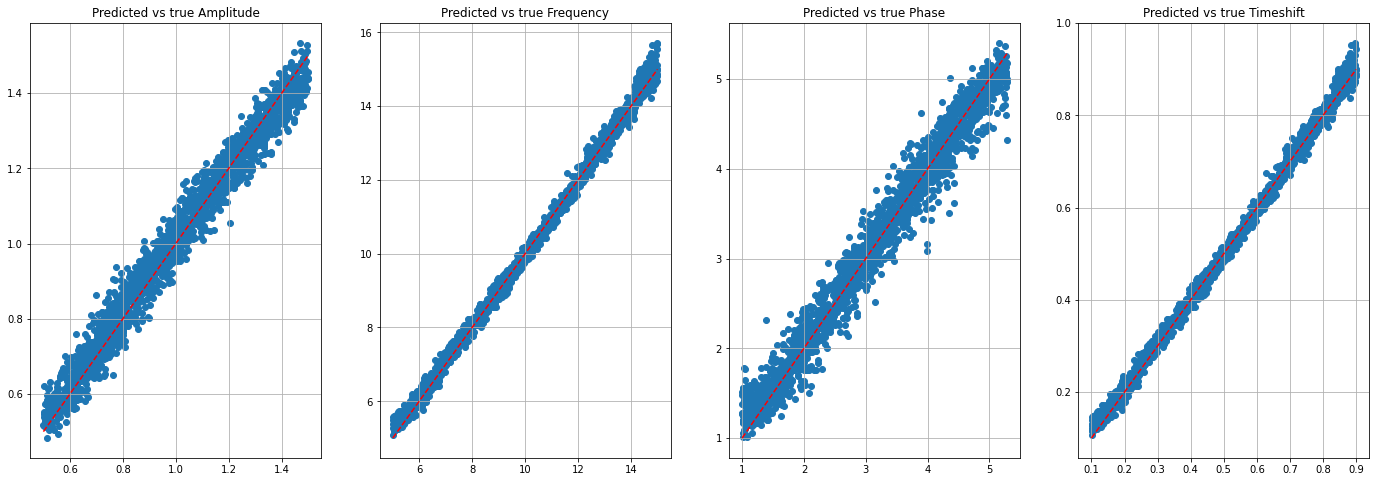

In [111]:
df_y_predict, performance = test_and_predict(model_pulse_timeshift_noisy_hilbert_autocorr, X_test, y_test)
y_test_unscaled = inverse_scale_features(y_test, scaler_iterations_w_timeshift)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_iterations_w_timeshift)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [112]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### 2 Pulses with variable timeshift

In [113]:
pulse_2_timeshift_traces_clean_hilbert_autocorr = hilbert_autocorr(pulse_2_timeshift_traces_clean)

In [114]:
pulse_2_timeshift_traces_clean_hilbert_autocorr.shape

(10000, 128, 4)

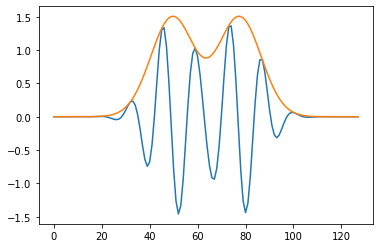

In [115]:
plt.plot(pulse_2_timeshift_traces_clean_hilbert_autocorr[1,:,0])
plt.plot(pulse_2_timeshift_traces_clean_hilbert_autocorr[1,:,1])

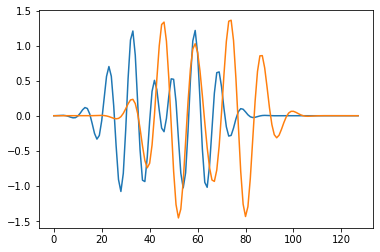

(8000, 128, 4) (8000, 5)
Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_2_pulses_timeshift_clean_hilbert_autocorr


<Figure size 1296x720 with 0 Axes>

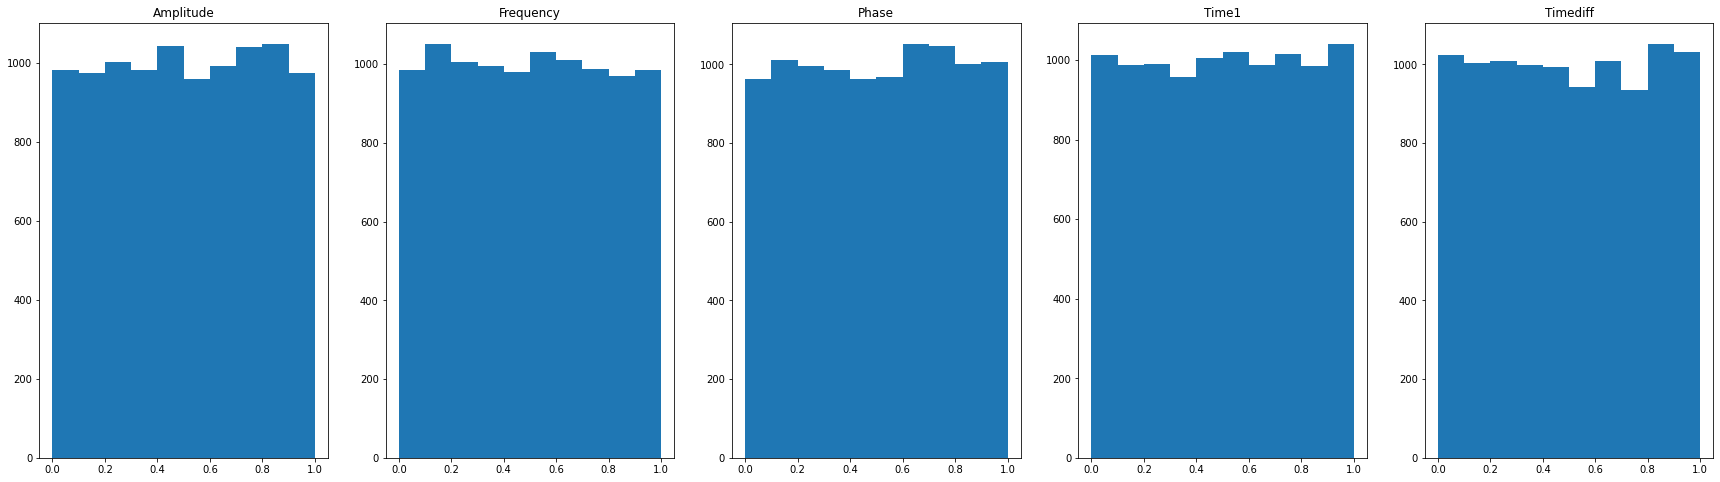

In [116]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_2_timeshift_traces_clean_hilbert_autocorr, df_2_pulses_timeshift_iterations_combined_norm, noiseon=False)
modelname = 'model_2_pulses_timeshift_clean_hilbert_autocorr'
model_2_pulses_timeshift_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

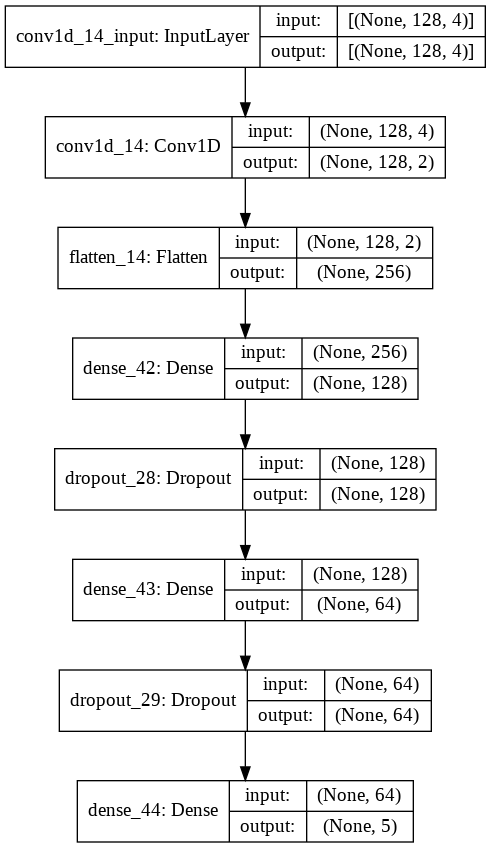

In [117]:
plot_model(model_2_pulses_timeshift_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.0837


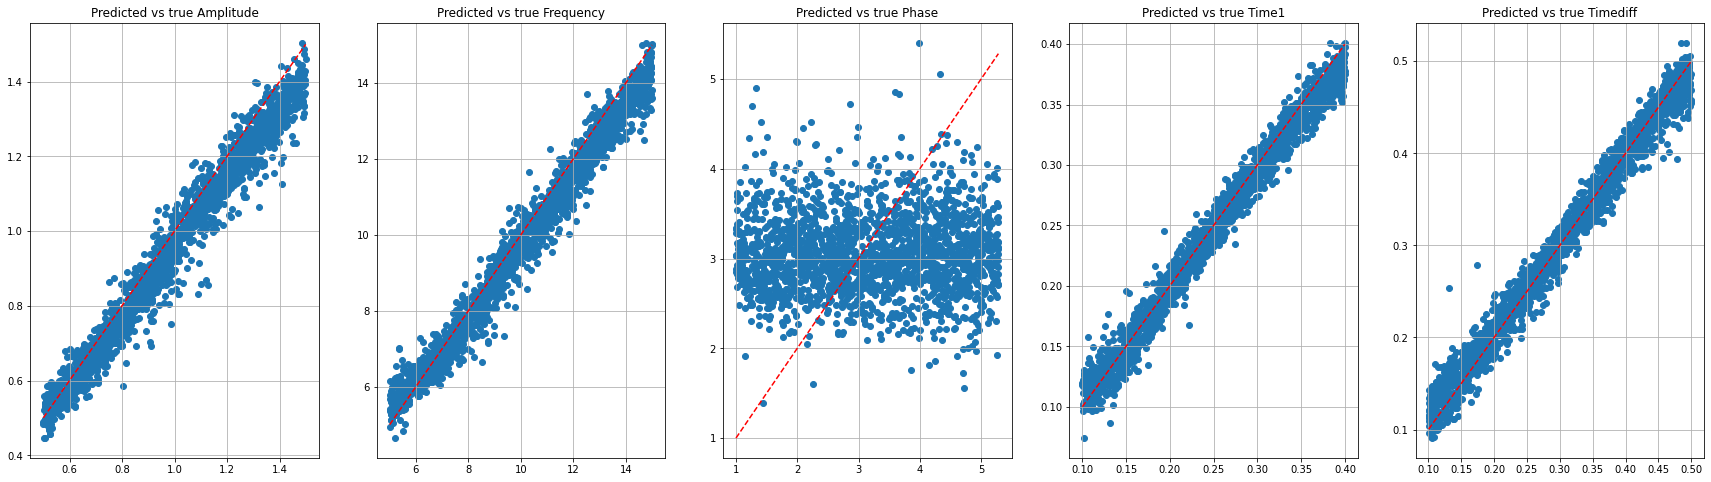

In [118]:
df_y_predict, performance = test_and_predict(model_2_pulses_timeshift_clean_hilbert_autocorr, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler_2_pulses_timeshift)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_2_pulses_timeshift)
plotprediction(y_test_unscaled, df_y_predict_unscaled)


In [119]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

In [120]:
pulse_2_timeshift_traces_noisy = add_noise(pulse_2_timeshift_traces_clean)
pulse_2_timeshift_traces_noisy_hilbert_autocorr = hilbert_autocorr(pulse_2_timeshift_traces_noisy)

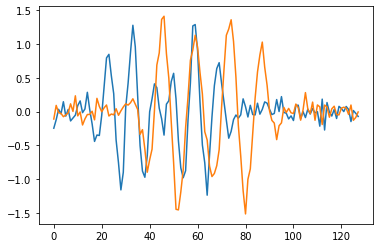

(8000, 128, 4) (8000, 5)
Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_2_pulses_timeshift_noisy_hilbert_autocorr


<Figure size 1296x720 with 0 Axes>

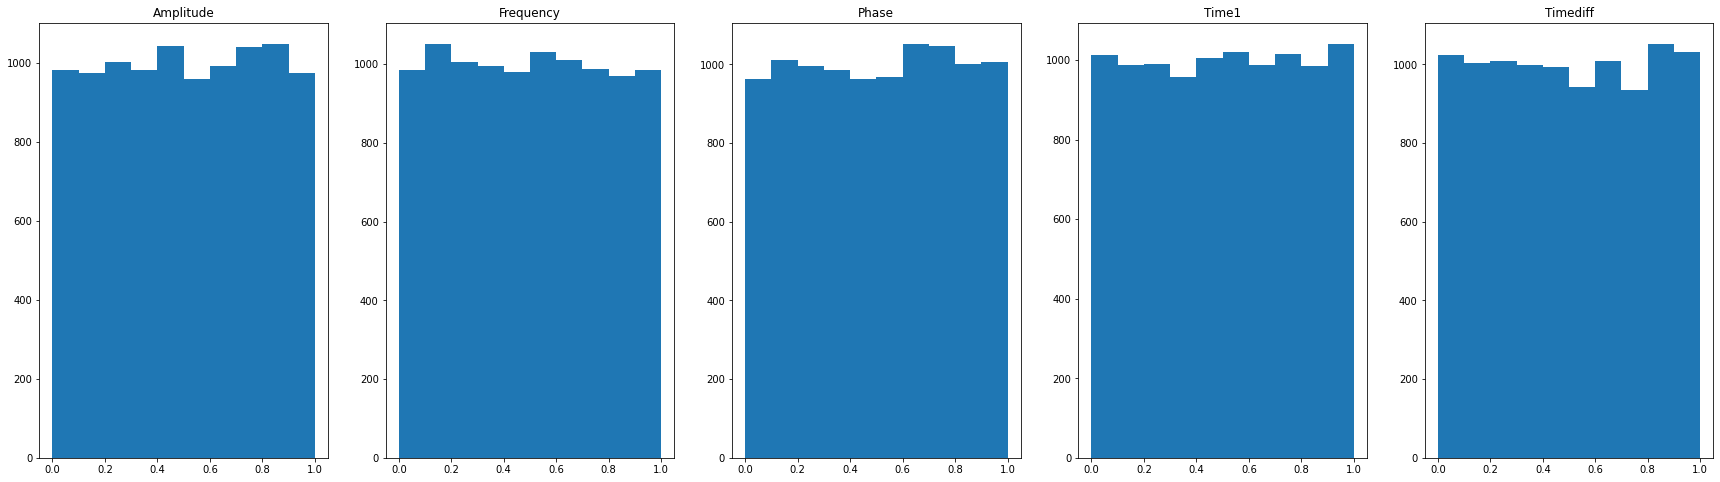

In [121]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_2_timeshift_traces_noisy_hilbert_autocorr, df_2_pulses_timeshift_iterations_combined_norm, noiseon=False)
modelname = 'model_2_pulses_timeshift_noisy_hilbert_autocorr'
model_2_pulses_timeshift_noisy_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

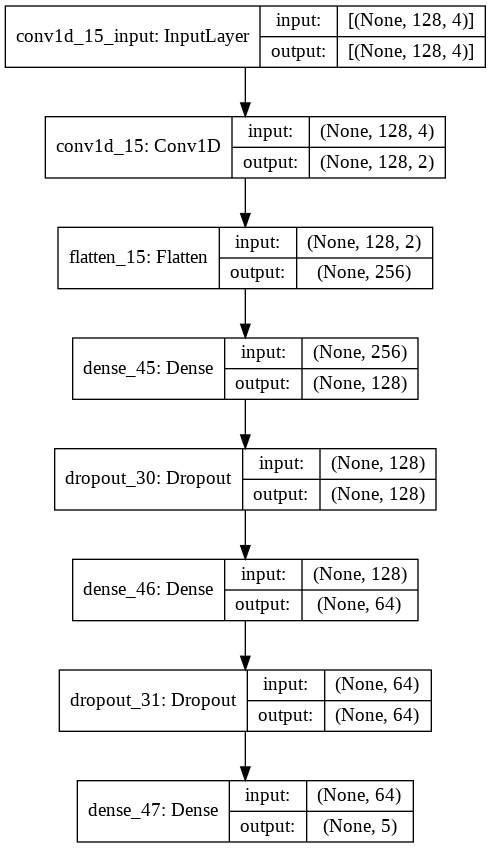

In [122]:
plot_model(model_2_pulses_timeshift_noisy_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0232 - mse: 0.0232 - mae: 0.0903


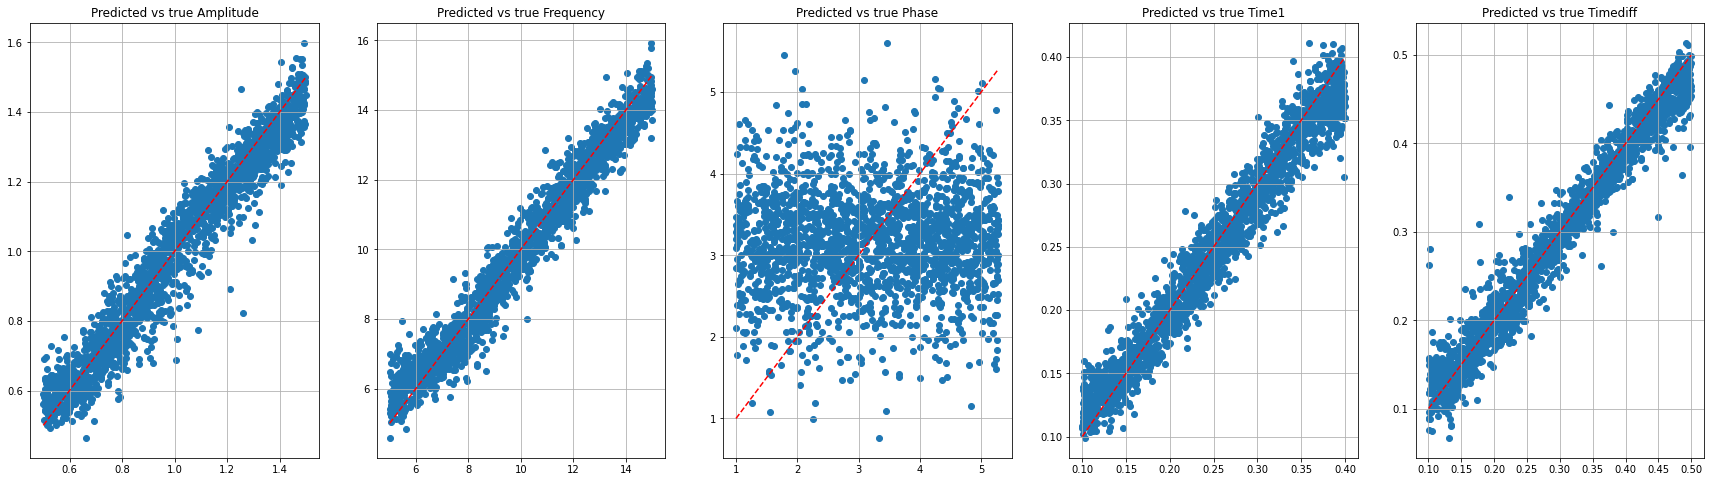

In [123]:
df_y_predict, performance = test_and_predict(model_2_pulses_timeshift_noisy_hilbert_autocorr, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler_2_pulses_timeshift)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_2_pulses_timeshift)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [124]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

## FFT

In [125]:
len(cw1_plus_cw2_clean)

10000

In [126]:
traces_fft = np.abs(fft(cw1_plus_cw2_clean))

In [127]:
len(traces_fft)

10000

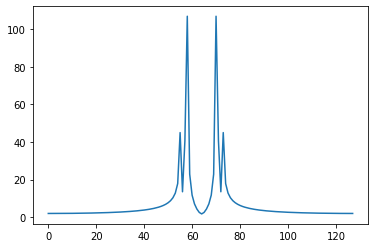

In [128]:
plt.plot(fftshift(traces_fft[0]))

In [129]:
len(traces_fft[0]), len(cw1_plus_cw2_clean[0])

(128, 128)

In [130]:
def make_fft(traces):
  traces_fft = fft(traces)
  amps = fftshift(np.abs(traces_fft))
  angles = fftshift(np.angle(traces_fft))
  return np.stack((traces, amps, angles), axis=-1)

In [131]:
cw1_plus_cw2_clean_fft = make_fft(cw1_plus_cw2_clean)

In [132]:
cw1_plus_cw2_clean_fft.shape

(10000, 128, 3)

In [133]:
#cw1_plus_cw2_clean_fft = np.expand_dims(cw1_plus_cw2_clean_fft, axis=2)

In [134]:
cw1_plus_cw2_clean_fft.shape

(10000, 128, 3)

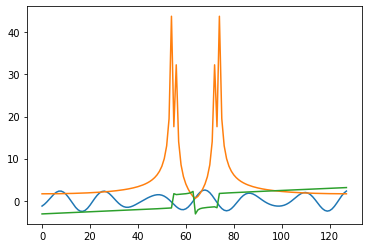

In [135]:
plt.plot(cw1_plus_cw2_clean_fft[0,:,0])
plt.plot(cw1_plus_cw2_clean_fft[0,:,1])
plt.plot(cw1_plus_cw2_clean_fft[0,:,2])
plt.show()

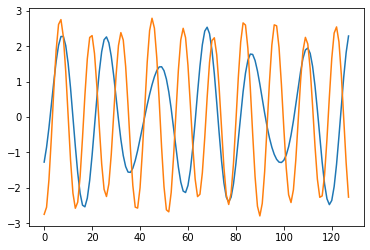

(8000, 128, 3) (8000, 6)
Model loaded: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_04/model_interfering_cw_clean_fft


<Figure size 1296x720 with 0 Axes>

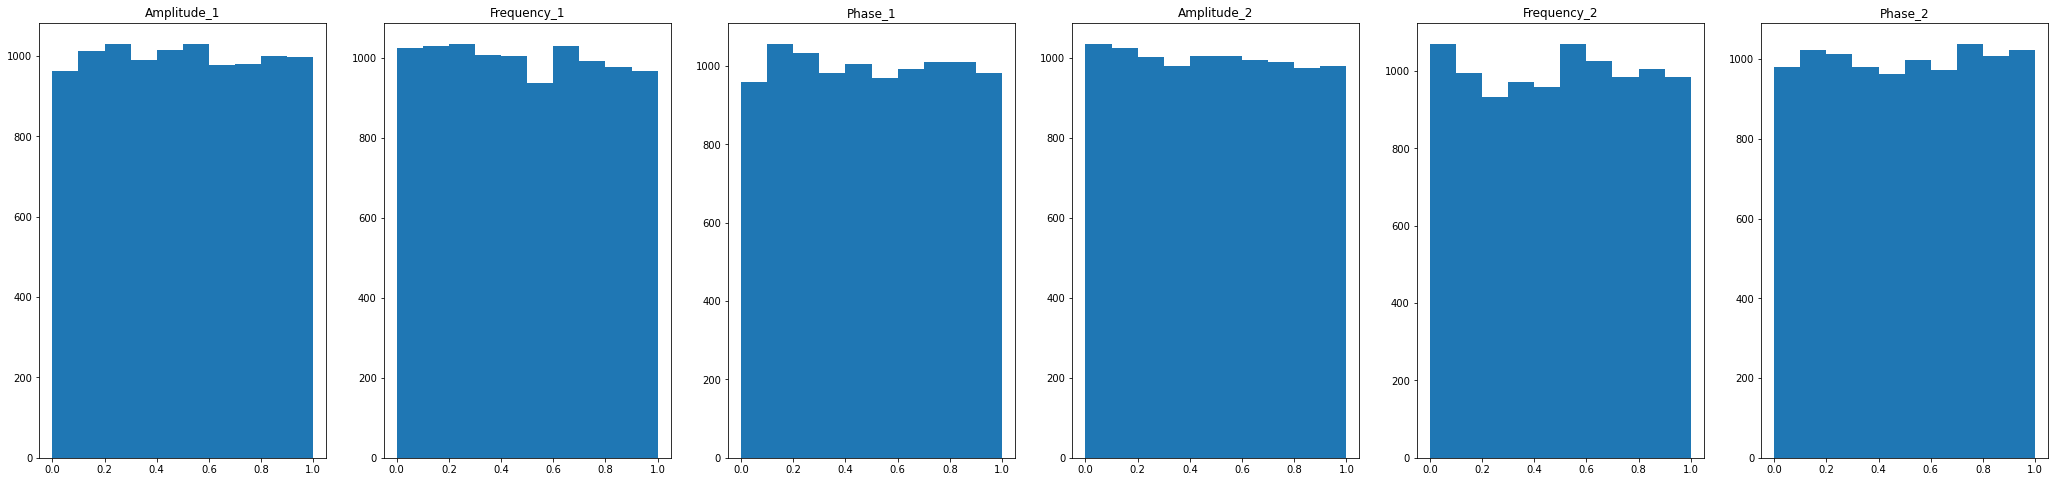

In [136]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(cw1_plus_cw2_clean_fft, df_iterations_interfering_cw_norm, noiseon=False)
modelname = 'model_interfering_cw_clean_fft'
model_interfering_cw_clean_fft = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

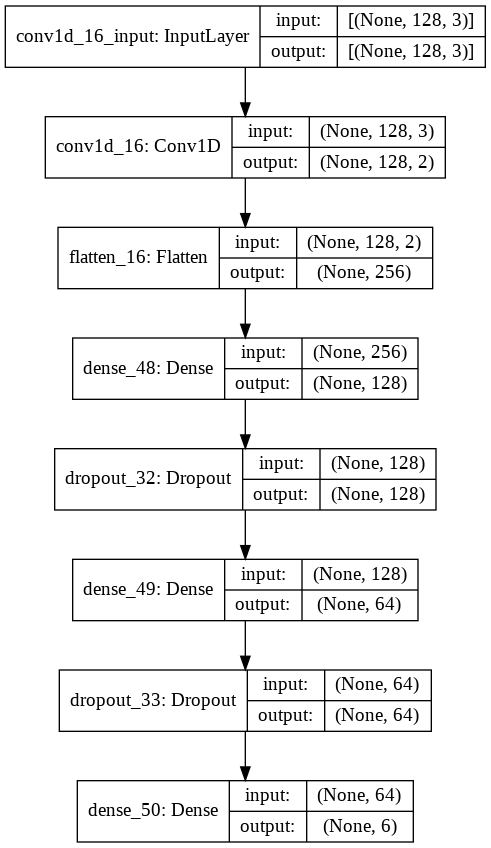

In [137]:
plot_model(model_interfering_cw_clean_fft, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 0s 2ms/step - loss: 0.0387 - mse: 0.0387 - mae: 0.1432


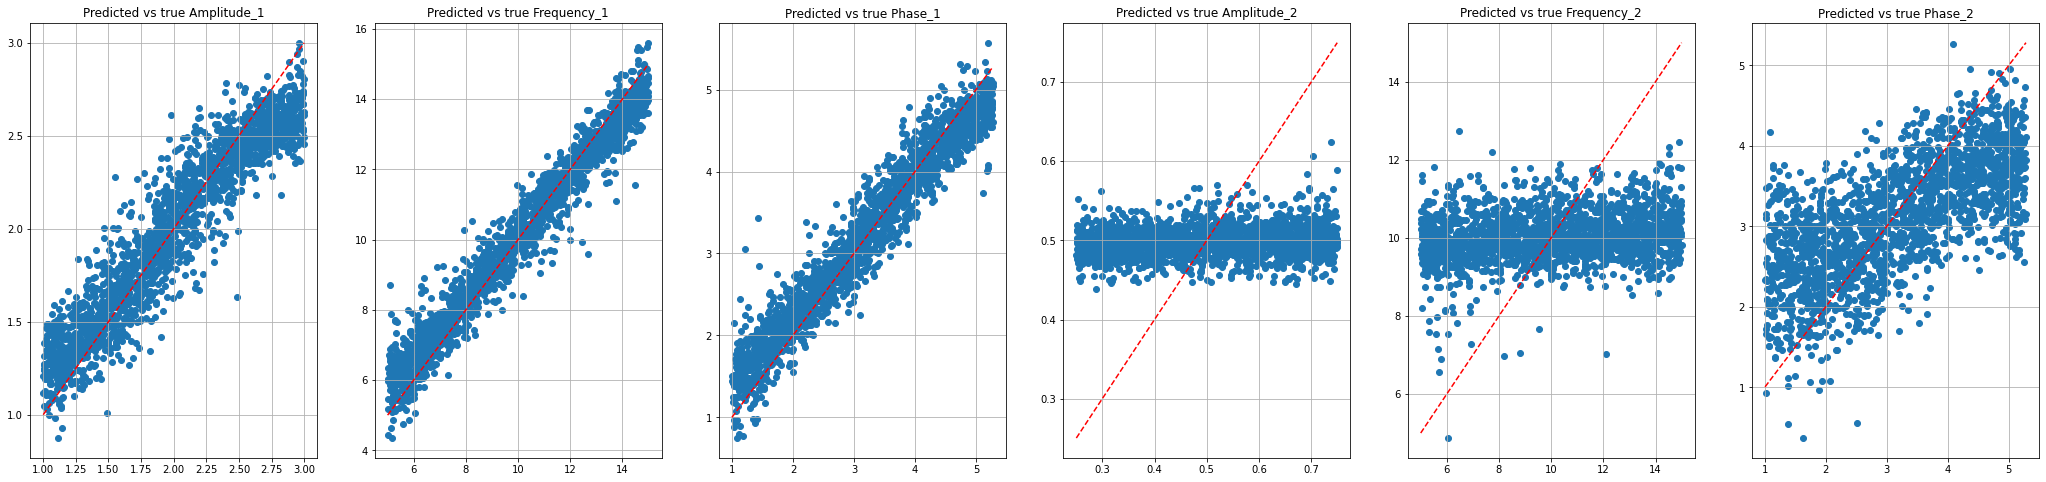

In [138]:
df_y_predict, performance = test_and_predict(model_interfering_cw_clean_fft, X_test, y_test)

y_test_unscaled = inverse_scale_features(y_test, scaler_interfering_cw)
df_y_predict_unscaled = inverse_scale_features(df_y_predict, scaler_interfering_cw)
plotprediction(y_test_unscaled, df_y_predict_unscaled)

In [139]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# Summary

In [140]:
df_performance

ModelName  ...       MAE
0                                    model_cw_clean  ...  0.012705
1                                    model_cw_noisy  ...  0.018332
2                                 model_pulse_clean  ...  0.022863
3                                 model_pulse_noisy  ...  0.077212
4                       model_pulse_timeshift_clean  ...  0.013600
5                       model_pulse_timeshift_noisy  ...  0.029290
6                    model_2_pulses_timeshift_clean  ...  0.084348
7                    model_2_pulses_timeshift_noisy  ...  0.097231
8                        model_interfering_cw_clean  ...  0.097879
9                        model_interfering_cw_noisy  ...  0.325476
10               model_pulse_clean_hilbert_autocorr  ...  0.015984
11               model_pulse_noisy_hilbert_autocorr  ...  0.057481
12     model_pulse_timeshift_clean_hilbert_autocorr  ...  0.016490
13     model_pulse_timeshift_noisy_hilbert_autocorr  ...  0.025149
14  model_2_pulses_timeshift_clean_hilbert_autocorr  ...  0.083700
15  model_2_pulses_timeshift_noisy_hilbert_autocorr  ...  0.090346
16                   model_interfering_cw_clean_fft  ...  0.143190

[17 rows x 4 columns]

In [141]:
dataframe_filename = 'model_performance.csv'
df_performance.to_csv(path+dataframe_filename)

# Observations

Increasing number of kernels above 2 exibits little improvement to the results.

A sample size of 10000 yields much better results than a sample size of 1000, but if the sample size is small, then preprocessing, like envelope detection and autocorrelations helps a lot. This makes sense, since the information is inherently in the trace. Pre-processing will extract some of that information and make it available to the CNN directly instead of the CNN having to learn to extract the same information, which requires more samples.

The scaling of the features prior to training is important to avoid that the higher valued features (frequency, for example) will get its error minimized on the cost of lower valued features (amplitude, for example).

Kernel length appears to have very little bearing on the results. Tester range: 2-32.

Why doesn't fft help?